In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle as pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the CSV dataset
dataset = pd.read_csv('/content/drive/MyDrive/final-dataset.csv')

In [5]:
dataset.drop(['Unnamed: 0'], inplace=True , axis=1)

In [6]:
# dataset.drop(['mesh'], inplace=True , axis=1)

In [7]:
dataset

person_id  \
0          CXR3695_IM-1845_0   
1          CXR3703_IM-1850_0   
2     CXR3686_IM-1837-0001_0   
3          CXR3677_IM-1830_0   
4          CXR3671_IM-1827_0   
...                      ...   
4261       CXR1883_IM-0572_0   
4262       CXR1889_IM-0577_0   
4263       CXR1842_IM-0545_0   
4264       CXR1863_IM-0558_0   
4265        CXR186_IM-0558_0   

                                                 image1  \
0     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
1     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
2     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
3     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
...                                                 ...   
4261  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4262  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4263  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4264  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4265  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 image2  \
0     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
1     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
2     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
3     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4     /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
...                                                 ...   
4261  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4262  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4263  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4264  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
4265  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 report  \
0     mild central vascular prominence congestion . ...   
1     no evidence acute cardiopulmonary process . th...   
2     stable cardiomegaly .  improved aeration the l...   
3     no active disease . heart size within normal l...   
4     persistent mild right upper lobe infiltrate si...   
...                                                 ...   
4261  no acute active cardiac pulmonary pleural dise...   
4262  atelectasis the right lung base .  elevated ri...   
4263  heart size normal .  lungs clear .  stable cal...   
4264  low volume study without acute process .  mild...   
4265  no acute cardiopulmonary abnormalities .  no e...   

                                                   mesh  
0                            Pulmonary Congestion/mild   
1                                               normal   
2     Cardiomegaly Airspace Disease/lung/base/right ...  
3                                       Aorta/tortuous   
4     Opacity/lung/upper lobe/right/patchy/mild Infi...  
...                                                 ...  
4261                Surgical Instruments/abdomen/right   
4262  Diaphragm/right/elevated Pulmonary Atelectasis...  
4263  Nodule/lung/middle lobe/right Calcinosis/lung/...  
4264  Cardiomegaly/mild Aorta/tortuous Lung/hypoinfl...  
4265                                            normal   

[4266 rows x 5 columns]

In [8]:
def train_test_split(data):
    persons_train = data[:2764]
    persons_test = data[2764:3153]
    persons_cv = data[3153:3707]
    return persons_train, persons_test, persons_cv

train_data, test_data, cv_data = train_test_split(dataset)

In [9]:
def remodelling(x):
    # adds start and end tokens to a sentence
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [10]:
train_data['report'] = train_data['report'].apply(lambda x : remodelling(x))
test_data['report'] = test_data['report'].apply(lambda x : remodelling(x))
cv_data['report'] = cv_data['report'].apply(lambda x : remodelling(x))

In [11]:
print('train data shape : ',train_data.shape)
train_data.head(2)

train data shape :  (2764, 5)


person_id                                             image1  \
0  CXR3695_IM-1845_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
1  CXR3703_IM-1850_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                              image2  \
0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
1  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                              report  \
0  startseq mild central vascular prominence cong...   
1  startseq no evidence acute cardiopulmonary pro...   

                         mesh  
0  Pulmonary Congestion/mild   
1                     normal

In [12]:
print('test data shape : ',test_data.shape)
test_data.head(2)

test data shape :  (389, 5)


person_id                                             image1  \
2764  CXR2349_IM-0914_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
2765  CXR2351_IM-0917_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 image2  \
2764  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
2765  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 report  \
2764  startseq normal chest . heart size and vascula...   
2765  startseq no acute cardiopulmonary disease . th...   

                                                   mesh  
2764                                            normal   
2765  Calcinosis/thorax/scattered/multiple Granuloma...

In [13]:
print('CV data shape : ',cv_data.shape)
cv_data.head(2)

CV data shape :  (554, 5)


person_id                                             image1  \
3153  CXR2700_IM-1169_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
3154  CXR2666_IM-1145_0  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 image2  \
3153  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   
3154  /content/drive/MyDrive/dataset-iu/dataset-iu-i...   

                                                 report  \
3153  startseq no acute findings . cardiac and media...   
3154  startseq stable appearing hyperinflated chest ...   

                                           mesh  
3153  Calcified Granuloma/mediastinum/multiple   
3154                      Lung/hyperdistention

In [14]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chexNet.input, outputs=X)

In [15]:
! gdown "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"

Downloading...
From: https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
To: /content/NLMCXR_png.tgz
100% 1.36G/1.36G [05:00<00:00, 4.53MB/s]


In [16]:
import shutil
shutil.unpack_archive("/content/NLMCXR_png.tgz","/content/NLMCXR_png")

In [17]:
! gdown "https://drive.google.com/u/0/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b&export=download"


Downloading...
From: https://drive.google.com/u/0/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b&export=download
To: /content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
100% 29.1M/29.1M [00:00<00:00, 95.1MB/s]


In [18]:
#loadind pretrained weights for ChexNet model
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [19]:
chexNet = Model(inputs = model.input, outputs = model.layers[-2].output)
chexNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

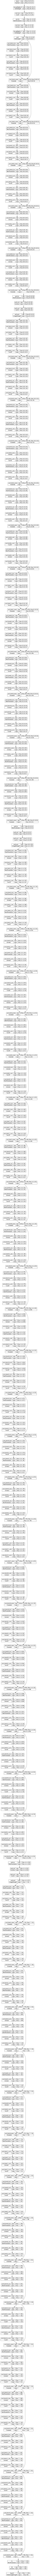

In [ ]:
tf.keras.utils.plot_model(chexNet,show_shapes=True, dpi = 42)

In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

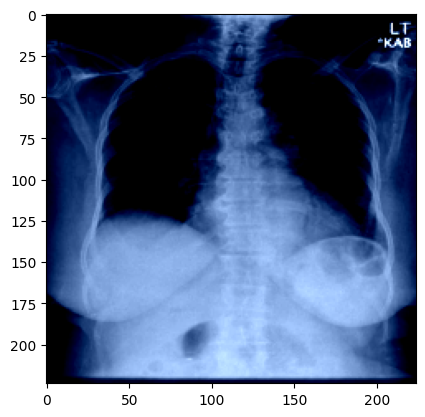

In [ ]:
img = load_image('NLMCXR_png/CXR1082_IM-0058-1001.png')
plt.imshow(img[0])

In [ ]:
Xnet_features = {}
for personid, img1, img2, report, mesh in tqdm(train_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[personid] = input_

for personid, img1, img2, report, mesh in tqdm(test_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[personid] = input_

for personid, img1, img2, report, mesh in tqdm(cv_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[personid] = input_

  0%|          | 0/2764 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/2764 [00:01<1:31:05,  1.98s/it]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/2764 [00:02<42:57,  1.07it/s]  

1/1 [==============================] - 0s 29ms/step


  0%|          | 3/2764 [00:02<27:31,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 4/2764 [00:02<20:15,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 5/2764 [00:02<16:37,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 6/2764 [00:03<14:06,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 7/2764 [00:03<12:27,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 8/2764 [00:03<11:35,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 9/2764 [00:03<10:53,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 10/2764 [00:03<10:27,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 11/2764 [00:04<10:01,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 12/2764 [00:04<09:55,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 13/2764 [00:04<09:48,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 14/2764 [00:04<09:35,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 15/2764 [00:04<09:30,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 16/2764 [00:05<09:22,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 17/2764 [00:05<09:14,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 18/2764 [00:05<09:08,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 19/2764 [00:05<09:10,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 20/2764 [00:05<09:09,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 21/2764 [00:06<09:12,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 22/2764 [00:06<09:06,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 23/2764 [00:06<09:02,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 24/2764 [00:06<09:06,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 25/2764 [00:06<09:12,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 26/2764 [00:07<09:08,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 27/2764 [00:07<09:25,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 28/2764 [00:07<09:23,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 29/2764 [00:07<09:19,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 30/2764 [00:07<09:21,  4.87it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 31/2764 [00:08<09:25,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 32/2764 [00:08<09:15,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 33/2764 [00:08<09:14,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 34/2764 [00:08<09:10,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 35/2764 [00:08<09:07,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 36/2764 [00:09<09:17,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 37/2764 [00:09<09:23,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 38/2764 [00:09<09:22,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 39/2764 [00:09<09:10,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 40/2764 [00:09<09:10,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 41/2764 [00:10<09:15,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 42/2764 [00:10<15:01,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 43/2764 [00:10<13:17,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 44/2764 [00:11<12:07,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 45/2764 [00:11<11:14,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 46/2764 [00:11<10:43,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 47/2764 [00:11<10:19,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 48/2764 [00:11<10:00,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 49/2764 [00:12<09:45,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 50/2764 [00:12<09:26,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 51/2764 [00:12<09:28,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 52/2764 [00:12<09:17,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 53/2764 [00:12<09:05,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 54/2764 [00:13<09:14,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 55/2764 [00:13<09:18,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 56/2764 [00:13<09:14,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 57/2764 [00:13<09:07,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 58/2764 [00:13<08:55,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 59/2764 [00:14<09:11,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 60/2764 [00:14<09:08,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 61/2764 [00:14<09:02,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 62/2764 [00:14<08:56,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 63/2764 [00:14<08:51,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 64/2764 [00:15<09:06,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 65/2764 [00:15<09:02,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 66/2764 [00:15<09:09,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 67/2764 [00:15<09:02,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 68/2764 [00:15<09:06,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 69/2764 [00:16<09:00,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 70/2764 [00:16<08:56,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 71/2764 [00:16<08:54,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 72/2764 [00:16<08:51,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 73/2764 [00:16<08:57,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 74/2764 [00:17<08:50,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 75/2764 [00:17<08:52,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 76/2764 [00:17<08:54,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 77/2764 [00:17<08:58,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 78/2764 [00:17<09:05,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 79/2764 [00:18<09:01,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 80/2764 [00:18<08:57,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 81/2764 [00:18<08:50,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 82/2764 [00:18<09:01,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 83/2764 [00:18<09:06,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 84/2764 [00:19<08:57,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 85/2764 [00:19<08:55,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 86/2764 [00:19<08:58,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 87/2764 [00:19<08:57,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 88/2764 [00:19<09:00,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 89/2764 [00:20<08:58,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 90/2764 [00:20<09:06,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 91/2764 [00:20<09:10,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 92/2764 [00:20<09:10,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 93/2764 [00:21<09:03,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 94/2764 [00:21<09:00,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 95/2764 [00:21<09:07,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 96/2764 [00:21<09:13,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 97/2764 [00:21<09:04,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 98/2764 [00:22<09:05,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 99/2764 [00:22<09:14,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 100/2764 [00:22<09:18,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 101/2764 [00:22<09:08,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 102/2764 [00:22<09:13,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 103/2764 [00:23<09:16,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 104/2764 [00:23<09:21,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 105/2764 [00:23<09:13,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 106/2764 [00:23<09:08,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 107/2764 [00:23<08:52,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 108/2764 [00:24<08:49,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 109/2764 [00:24<08:57,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 110/2764 [00:24<08:47,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 111/2764 [00:24<08:42,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 112/2764 [00:24<08:50,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 113/2764 [00:25<08:48,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 114/2764 [00:25<08:46,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 115/2764 [00:25<08:46,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 116/2764 [00:25<08:46,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 117/2764 [00:25<08:41,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 118/2764 [00:26<08:47,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 119/2764 [00:26<08:47,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 120/2764 [00:26<08:46,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 121/2764 [00:26<08:36,  5.11it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 122/2764 [00:26<08:52,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 123/2764 [00:27<08:47,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 124/2764 [00:27<08:53,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 125/2764 [00:27<09:02,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 126/2764 [00:27<08:55,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 127/2764 [00:27<09:04,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 128/2764 [00:28<08:52,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 129/2764 [00:28<08:43,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 130/2764 [00:28<08:40,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 131/2764 [00:28<08:56,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 132/2764 [00:28<08:50,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 133/2764 [00:29<08:45,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 134/2764 [00:29<08:41,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 135/2764 [00:29<08:45,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 136/2764 [00:29<08:54,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 137/2764 [00:29<08:44,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 138/2764 [00:30<08:44,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 139/2764 [00:30<08:44,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 140/2764 [00:30<08:41,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 141/2764 [00:30<08:42,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 142/2764 [00:30<08:52,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 143/2764 [00:31<08:55,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 144/2764 [00:31<08:58,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 145/2764 [00:31<09:01,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 146/2764 [00:31<08:55,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 147/2764 [00:31<08:57,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 148/2764 [00:32<08:48,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 149/2764 [00:32<09:02,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 150/2764 [00:32<09:03,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 151/2764 [00:32<09:01,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 152/2764 [00:32<08:56,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 153/2764 [00:33<08:56,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 154/2764 [00:33<08:51,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 155/2764 [00:33<08:52,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 156/2764 [00:33<08:55,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 157/2764 [00:34<08:55,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 158/2764 [00:34<08:55,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 159/2764 [00:34<08:54,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 160/2764 [00:34<08:51,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 161/2764 [00:34<08:43,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 162/2764 [00:35<08:50,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 163/2764 [00:35<08:52,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 164/2764 [00:35<08:48,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 165/2764 [00:35<08:53,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 166/2764 [00:35<08:49,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 167/2764 [00:36<08:49,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 168/2764 [00:36<08:43,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 169/2764 [00:36<08:38,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 170/2764 [00:36<08:36,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 171/2764 [00:36<08:48,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 172/2764 [00:37<08:45,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 173/2764 [00:37<08:41,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 174/2764 [00:37<08:51,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 175/2764 [00:37<08:53,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 176/2764 [00:37<08:52,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 177/2764 [00:38<08:48,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 178/2764 [00:38<08:41,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 179/2764 [00:38<08:38,  4.99it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 180/2764 [00:38<08:42,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 181/2764 [00:38<08:40,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 182/2764 [00:39<08:38,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 183/2764 [00:39<08:35,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 184/2764 [00:39<08:32,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 185/2764 [00:39<08:39,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 186/2764 [00:39<08:37,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 187/2764 [00:40<08:33,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 188/2764 [00:40<08:27,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 189/2764 [00:40<08:30,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 190/2764 [00:40<08:30,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 191/2764 [00:40<08:31,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 192/2764 [00:41<08:28,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 193/2764 [00:41<08:35,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 194/2764 [00:41<08:38,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 195/2764 [00:41<08:33,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 196/2764 [00:41<08:27,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 197/2764 [00:42<08:26,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 198/2764 [00:42<08:31,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 199/2764 [00:42<08:31,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 200/2764 [00:42<08:32,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 201/2764 [00:42<08:30,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 202/2764 [00:43<08:29,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 203/2764 [00:43<08:37,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 204/2764 [00:43<08:38,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 205/2764 [00:43<08:36,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 206/2764 [00:43<08:30,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 207/2764 [00:44<08:33,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 208/2764 [00:44<08:36,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 209/2764 [00:44<08:34,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 210/2764 [00:44<08:34,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 211/2764 [00:44<08:41,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 212/2764 [00:45<08:56,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 213/2764 [00:45<08:55,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 214/2764 [00:45<08:46,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 215/2764 [00:45<08:44,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 216/2764 [00:45<08:46,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 217/2764 [00:46<08:39,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 218/2764 [00:46<08:38,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 219/2764 [00:46<08:33,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 220/2764 [00:46<08:39,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 221/2764 [00:46<08:45,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 222/2764 [00:47<08:37,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 223/2764 [00:47<08:31,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 224/2764 [00:47<08:34,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 225/2764 [00:47<08:45,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 226/2764 [00:47<08:35,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 227/2764 [00:48<08:40,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 228/2764 [00:48<08:34,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 229/2764 [00:48<08:45,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 230/2764 [00:48<08:39,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 231/2764 [00:48<08:44,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 232/2764 [00:49<08:43,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 233/2764 [00:49<08:37,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 234/2764 [00:49<08:41,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 235/2764 [00:49<08:35,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 236/2764 [00:50<08:38,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 237/2764 [00:50<08:33,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 238/2764 [00:50<08:38,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 239/2764 [00:50<08:33,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 240/2764 [00:50<08:27,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 241/2764 [00:51<08:36,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 242/2764 [00:51<08:33,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 243/2764 [00:51<08:32,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 244/2764 [00:51<08:30,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 245/2764 [00:51<08:35,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 246/2764 [00:52<08:38,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 247/2764 [00:52<08:47,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 248/2764 [00:52<08:50,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 249/2764 [00:52<08:35,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 250/2764 [00:52<08:39,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 251/2764 [00:53<08:37,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 252/2764 [00:53<08:37,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 253/2764 [00:53<08:31,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 254/2764 [00:53<08:36,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 255/2764 [00:53<08:36,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 256/2764 [00:54<08:38,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 257/2764 [00:54<08:37,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 258/2764 [00:54<08:38,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 259/2764 [00:54<08:31,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 260/2764 [00:54<08:21,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 261/2764 [00:55<08:29,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 262/2764 [00:55<08:30,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 263/2764 [00:55<08:26,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 264/2764 [00:55<08:23,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 265/2764 [00:55<08:32,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 266/2764 [00:56<08:29,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 267/2764 [00:56<08:26,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 268/2764 [00:56<08:26,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 269/2764 [00:56<08:18,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 270/2764 [00:56<08:28,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 271/2764 [00:57<08:41,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 272/2764 [00:57<08:33,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 273/2764 [00:57<08:26,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 274/2764 [00:57<08:23,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 275/2764 [00:57<08:25,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 276/2764 [00:58<08:31,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 277/2764 [00:58<08:27,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 278/2764 [00:58<08:32,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 279/2764 [00:58<08:42,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 280/2764 [00:59<08:32,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 281/2764 [00:59<08:40,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 282/2764 [00:59<08:34,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 283/2764 [00:59<08:31,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 284/2764 [00:59<08:27,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 285/2764 [01:00<08:22,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 286/2764 [01:00<08:17,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 287/2764 [01:00<08:16,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 288/2764 [01:00<08:14,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 289/2764 [01:00<08:04,  5.10it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 290/2764 [01:01<07:59,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 291/2764 [01:01<07:54,  5.21it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 292/2764 [01:01<08:02,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 293/2764 [01:01<08:06,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 294/2764 [01:01<08:06,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 295/2764 [01:01<08:05,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 296/2764 [01:02<08:19,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 297/2764 [01:02<08:26,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 298/2764 [01:02<08:19,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 299/2764 [01:02<08:13,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 300/2764 [01:03<08:09,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 301/2764 [01:03<08:17,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 302/2764 [01:03<08:19,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 303/2764 [01:03<08:14,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 304/2764 [01:03<08:14,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 305/2764 [01:04<08:13,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 306/2764 [01:04<08:28,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 307/2764 [01:04<08:22,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 308/2764 [01:04<08:25,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 309/2764 [01:04<08:21,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 310/2764 [01:05<08:23,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 311/2764 [01:05<08:17,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 312/2764 [01:05<08:17,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 313/2764 [01:05<08:13,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 314/2764 [01:05<08:09,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 315/2764 [01:06<08:08,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 316/2764 [01:06<08:00,  5.09it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 317/2764 [01:06<07:59,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 318/2764 [01:06<07:52,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 319/2764 [01:06<07:58,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 320/2764 [01:07<07:53,  5.16it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 321/2764 [01:07<07:57,  5.12it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 322/2764 [01:07<08:07,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 323/2764 [01:07<08:05,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 324/2764 [01:07<08:20,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 325/2764 [01:08<08:19,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 326/2764 [01:08<08:16,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 327/2764 [01:08<08:12,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 328/2764 [01:08<08:13,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 329/2764 [01:08<08:13,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 330/2764 [01:09<08:05,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 331/2764 [01:09<08:04,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 332/2764 [01:09<08:08,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 333/2764 [01:09<08:23,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 334/2764 [01:09<08:14,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 335/2764 [01:10<08:10,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 336/2764 [01:10<08:11,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 337/2764 [01:10<08:16,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 338/2764 [01:10<08:14,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 339/2764 [01:10<08:09,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 340/2764 [01:11<08:11,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 341/2764 [01:11<08:03,  5.01it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 342/2764 [01:11<08:16,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 343/2764 [01:11<08:15,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 344/2764 [01:11<08:16,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 345/2764 [01:12<08:07,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 346/2764 [01:12<08:11,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 347/2764 [01:12<08:06,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 348/2764 [01:12<08:04,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 349/2764 [01:12<08:08,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 350/2764 [01:13<07:57,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 351/2764 [01:13<08:11,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 352/2764 [01:13<08:16,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 353/2764 [01:13<08:11,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 354/2764 [01:13<08:11,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 355/2764 [01:14<08:10,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 356/2764 [01:14<08:12,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 357/2764 [01:14<08:19,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 358/2764 [01:14<08:19,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 359/2764 [01:14<08:23,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 360/2764 [01:15<08:11,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 361/2764 [01:15<08:08,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 362/2764 [01:15<08:06,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 363/2764 [01:15<08:01,  4.99it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 364/2764 [01:15<08:06,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 365/2764 [01:16<08:04,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 366/2764 [01:16<08:02,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 367/2764 [01:16<08:03,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 368/2764 [01:16<08:07,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 369/2764 [01:16<08:07,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 370/2764 [01:17<08:04,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 371/2764 [01:17<08:02,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 372/2764 [01:17<07:57,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 373/2764 [01:17<07:56,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 374/2764 [01:17<07:57,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 375/2764 [01:18<07:56,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 376/2764 [01:18<07:55,  5.02it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 377/2764 [01:18<08:11,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 378/2764 [01:18<08:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 379/2764 [01:18<08:09,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 380/2764 [01:19<08:10,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 381/2764 [01:19<08:07,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 382/2764 [01:19<08:14,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 383/2764 [01:19<08:09,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 384/2764 [01:20<08:12,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 385/2764 [01:20<08:09,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 386/2764 [01:20<08:09,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 387/2764 [01:20<08:05,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 388/2764 [01:20<08:01,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 389/2764 [01:21<07:48,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 390/2764 [01:21<07:48,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 391/2764 [01:21<07:55,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 392/2764 [01:21<07:56,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 393/2764 [01:21<08:07,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 394/2764 [01:22<08:14,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 395/2764 [01:22<08:09,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 396/2764 [01:22<08:06,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 397/2764 [01:22<08:00,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 398/2764 [01:22<08:01,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 399/2764 [01:23<08:01,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 400/2764 [01:23<07:59,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 401/2764 [01:23<07:56,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 402/2764 [01:23<08:01,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 403/2764 [01:23<08:01,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 404/2764 [01:24<08:03,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 405/2764 [01:24<07:58,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 406/2764 [01:24<07:55,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 407/2764 [01:24<07:56,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 408/2764 [01:24<07:57,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 409/2764 [01:25<08:05,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 410/2764 [01:25<08:00,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 411/2764 [01:25<07:58,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 412/2764 [01:25<07:55,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 413/2764 [01:25<07:55,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 414/2764 [01:26<07:55,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 415/2764 [01:26<07:54,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 416/2764 [01:26<07:54,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 417/2764 [01:26<07:58,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 418/2764 [01:26<07:55,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 419/2764 [01:27<07:45,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 420/2764 [01:27<07:53,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 421/2764 [01:27<07:49,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 422/2764 [01:27<07:52,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 423/2764 [01:27<07:46,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 424/2764 [01:28<07:47,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 425/2764 [01:28<07:44,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 426/2764 [01:28<07:47,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 427/2764 [01:28<07:55,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 428/2764 [01:28<08:06,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 429/2764 [01:29<07:58,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 430/2764 [01:29<07:47,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 431/2764 [01:29<07:51,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 432/2764 [01:29<07:49,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 433/2764 [01:29<07:45,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 434/2764 [01:30<07:43,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 435/2764 [01:30<07:48,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 436/2764 [01:30<07:46,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 437/2764 [01:30<07:43,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 438/2764 [01:30<07:44,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 439/2764 [01:31<07:50,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 440/2764 [01:31<07:54,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 441/2764 [01:31<07:51,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 442/2764 [01:31<07:48,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 443/2764 [01:31<07:56,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 444/2764 [01:32<07:55,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 445/2764 [01:32<07:50,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 446/2764 [01:32<07:46,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 447/2764 [01:32<07:37,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 448/2764 [01:32<07:44,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 449/2764 [01:33<07:50,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 450/2764 [01:33<07:47,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 451/2764 [01:33<07:46,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 452/2764 [01:33<07:51,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 453/2764 [01:34<07:58,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 454/2764 [01:34<07:57,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 455/2764 [01:34<07:53,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 456/2764 [01:34<07:49,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 457/2764 [01:34<07:53,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 458/2764 [01:35<08:02,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 459/2764 [01:35<07:56,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 460/2764 [01:35<08:03,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 461/2764 [01:35<07:55,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 462/2764 [01:35<08:06,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 463/2764 [01:36<08:14,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 464/2764 [01:36<08:03,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 465/2764 [01:36<08:05,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 466/2764 [01:36<07:57,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 467/2764 [01:36<07:57,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 468/2764 [01:37<07:47,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 469/2764 [01:37<07:42,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 470/2764 [01:37<07:42,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 471/2764 [01:37<07:36,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 472/2764 [01:37<07:39,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 473/2764 [01:38<07:32,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 474/2764 [01:38<07:28,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 475/2764 [01:38<07:31,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 476/2764 [01:38<07:46,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 477/2764 [01:38<07:50,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 478/2764 [01:39<07:44,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 479/2764 [01:39<07:43,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 480/2764 [01:39<07:46,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 481/2764 [01:39<07:43,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 482/2764 [01:39<07:40,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 483/2764 [01:40<07:52,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 484/2764 [01:40<07:48,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 485/2764 [01:40<07:44,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 486/2764 [01:40<07:39,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 487/2764 [01:40<07:37,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 488/2764 [01:41<07:37,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 489/2764 [01:41<07:31,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 490/2764 [01:41<07:32,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 491/2764 [01:41<07:32,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 492/2764 [01:41<07:33,  5.01it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 493/2764 [01:42<07:38,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 494/2764 [01:42<07:38,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 495/2764 [01:42<07:39,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 496/2764 [01:42<07:45,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 497/2764 [01:42<07:40,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 498/2764 [01:43<07:48,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 499/2764 [01:43<07:44,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 500/2764 [01:43<07:44,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 501/2764 [01:43<07:46,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 502/2764 [01:44<07:53,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 503/2764 [01:44<07:56,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 504/2764 [01:44<07:55,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 505/2764 [01:44<07:45,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 506/2764 [01:44<07:48,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 507/2764 [01:45<07:51,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 508/2764 [01:45<07:46,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 509/2764 [01:45<07:44,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 510/2764 [01:45<07:38,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 511/2764 [01:45<07:41,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 512/2764 [01:46<07:47,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 513/2764 [01:46<07:40,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 514/2764 [01:46<07:34,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 515/2764 [01:46<07:34,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 516/2764 [01:46<07:37,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 517/2764 [01:47<07:42,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 518/2764 [01:47<07:40,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 519/2764 [01:47<07:37,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 520/2764 [01:47<07:46,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 521/2764 [01:47<07:46,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 522/2764 [01:48<07:44,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 523/2764 [01:48<07:49,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 524/2764 [01:48<07:42,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 525/2764 [01:48<07:48,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 526/2764 [01:48<07:40,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 527/2764 [01:49<07:35,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 528/2764 [01:49<07:43,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 529/2764 [01:49<07:40,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 530/2764 [01:49<07:32,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 531/2764 [01:49<07:35,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 532/2764 [01:50<07:42,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 533/2764 [01:50<07:50,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 534/2764 [01:50<07:43,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 535/2764 [01:50<07:34,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 536/2764 [01:51<07:35,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 537/2764 [01:51<07:36,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 538/2764 [01:51<07:37,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 539/2764 [01:51<07:40,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 540/2764 [01:51<07:35,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 541/2764 [01:52<07:30,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 542/2764 [01:52<07:33,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 543/2764 [01:52<07:31,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 544/2764 [01:52<07:28,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 545/2764 [01:52<07:31,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 546/2764 [01:53<07:30,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 547/2764 [01:53<07:30,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 548/2764 [01:53<07:37,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 549/2764 [01:53<07:28,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 550/2764 [01:53<07:26,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 551/2764 [01:54<07:36,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 552/2764 [01:54<07:33,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 553/2764 [01:54<07:32,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 554/2764 [01:54<07:35,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 555/2764 [01:54<07:36,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 556/2764 [01:55<07:38,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 557/2764 [01:55<07:35,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 558/2764 [01:55<07:31,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 559/2764 [01:55<07:22,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 560/2764 [01:55<07:30,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 561/2764 [01:56<07:29,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 562/2764 [01:56<07:25,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 563/2764 [01:56<07:18,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 564/2764 [01:56<07:16,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 565/2764 [01:56<07:22,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 566/2764 [01:57<07:21,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 567/2764 [01:57<07:13,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 568/2764 [01:57<07:24,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 569/2764 [01:57<07:27,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 570/2764 [01:57<07:24,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 571/2764 [01:58<07:23,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 572/2764 [01:58<07:20,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 573/2764 [01:58<07:33,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 574/2764 [01:58<07:38,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 575/2764 [01:58<07:25,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 576/2764 [01:59<07:25,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 577/2764 [01:59<07:31,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 578/2764 [01:59<07:34,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 579/2764 [01:59<07:43,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 580/2764 [02:00<07:38,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 581/2764 [02:00<07:35,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 582/2764 [02:00<07:44,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 583/2764 [02:00<07:39,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 584/2764 [02:00<07:31,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 585/2764 [02:01<07:27,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 586/2764 [02:01<07:25,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 587/2764 [02:01<07:31,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 588/2764 [02:01<07:41,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 589/2764 [02:01<07:34,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 590/2764 [02:02<07:29,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 591/2764 [02:02<07:26,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 592/2764 [02:02<07:25,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 593/2764 [02:02<07:21,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 594/2764 [02:02<07:19,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 595/2764 [02:03<07:21,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 596/2764 [02:03<07:23,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 597/2764 [02:03<07:22,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 598/2764 [02:03<07:24,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 599/2764 [02:03<07:18,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 600/2764 [02:04<07:23,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 601/2764 [02:04<07:22,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 602/2764 [02:04<07:14,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 603/2764 [02:04<07:11,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 604/2764 [02:04<07:13,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 605/2764 [02:05<07:11,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 606/2764 [02:05<07:18,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 607/2764 [02:05<07:09,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 608/2764 [02:05<07:10,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 609/2764 [02:05<07:12,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 610/2764 [02:06<07:12,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 611/2764 [02:06<07:10,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 612/2764 [02:06<07:06,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 613/2764 [02:06<07:10,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 614/2764 [02:06<07:12,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 615/2764 [02:07<07:13,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 616/2764 [02:07<07:11,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 617/2764 [02:07<07:10,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 618/2764 [02:07<07:16,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 619/2764 [02:07<07:14,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 620/2764 [02:08<07:21,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 621/2764 [02:08<07:25,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 622/2764 [02:08<07:22,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 623/2764 [02:08<07:18,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 624/2764 [02:08<07:16,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 625/2764 [02:09<07:14,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 626/2764 [02:09<07:18,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 627/2764 [02:09<07:16,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 628/2764 [02:09<07:19,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 629/2764 [02:09<07:14,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 630/2764 [02:10<07:12,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 631/2764 [02:10<07:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 632/2764 [02:10<07:14,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 633/2764 [02:10<07:12,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 634/2764 [02:10<07:10,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 635/2764 [02:11<07:12,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 636/2764 [02:11<07:15,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 637/2764 [02:11<07:12,  4.92it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 638/2764 [02:11<07:17,  4.86it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 639/2764 [02:12<07:10,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 640/2764 [02:12<07:15,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 641/2764 [02:12<07:18,  4.84it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 642/2764 [02:12<07:27,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 643/2764 [02:12<07:22,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 644/2764 [02:13<07:23,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 645/2764 [02:13<07:19,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 646/2764 [02:13<07:09,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 647/2764 [02:13<07:08,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 648/2764 [02:13<07:14,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 649/2764 [02:14<07:17,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 650/2764 [02:14<07:14,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 651/2764 [02:14<07:19,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 652/2764 [02:14<07:15,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 653/2764 [02:14<07:22,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 654/2764 [02:15<07:11,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 655/2764 [02:15<07:09,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 656/2764 [02:15<07:07,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 657/2764 [02:15<07:00,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 658/2764 [02:15<07:03,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 659/2764 [02:16<07:00,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 660/2764 [02:16<06:59,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 661/2764 [02:16<07:00,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 662/2764 [02:16<07:02,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 663/2764 [02:16<07:02,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 664/2764 [02:17<06:57,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 665/2764 [02:17<07:04,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 666/2764 [02:17<07:10,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 667/2764 [02:17<07:18,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 668/2764 [02:17<07:05,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 669/2764 [02:18<07:05,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 670/2764 [02:18<07:04,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 671/2764 [02:18<07:07,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 672/2764 [02:18<07:01,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 673/2764 [02:18<07:01,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 674/2764 [02:19<06:53,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 675/2764 [02:19<06:53,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 676/2764 [02:19<07:04,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 677/2764 [02:19<06:59,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 678/2764 [02:19<07:01,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 679/2764 [02:20<07:02,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 680/2764 [02:20<07:04,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 681/2764 [02:20<07:04,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 682/2764 [02:20<07:00,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 683/2764 [02:20<07:00,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 684/2764 [02:21<06:57,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 685/2764 [02:21<07:02,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 686/2764 [02:21<07:05,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 687/2764 [02:21<07:02,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 688/2764 [02:21<06:59,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 689/2764 [02:22<07:00,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 690/2764 [02:22<06:52,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 691/2764 [02:22<06:54,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 692/2764 [02:22<06:53,  5.02it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 693/2764 [02:23<07:11,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 694/2764 [02:23<07:19,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 695/2764 [02:23<07:16,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 696/2764 [02:23<07:07,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 697/2764 [02:23<07:08,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 698/2764 [02:24<07:08,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 699/2764 [02:24<07:03,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 700/2764 [02:24<07:07,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 701/2764 [02:24<07:09,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 702/2764 [02:24<07:13,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 703/2764 [02:25<07:09,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 704/2764 [02:25<07:10,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 705/2764 [02:25<07:14,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 706/2764 [02:25<07:14,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 707/2764 [02:25<07:14,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 708/2764 [02:26<07:12,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 709/2764 [02:26<07:04,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 710/2764 [02:26<07:07,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 711/2764 [02:26<07:08,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 712/2764 [02:26<07:02,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 713/2764 [02:27<07:02,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 714/2764 [02:27<07:02,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 715/2764 [02:27<07:03,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 716/2764 [02:27<07:00,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 717/2764 [02:28<07:06,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 718/2764 [02:28<07:05,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 719/2764 [02:28<07:09,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 720/2764 [02:28<07:16,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 721/2764 [02:28<07:10,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 722/2764 [02:29<07:02,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 723/2764 [02:29<06:57,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 724/2764 [02:29<06:56,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 725/2764 [02:29<06:54,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 726/2764 [02:29<06:51,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 727/2764 [02:30<06:58,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 728/2764 [02:30<06:57,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 729/2764 [02:30<07:03,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 730/2764 [02:30<07:00,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 731/2764 [02:30<06:54,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 732/2764 [02:31<07:00,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 733/2764 [02:31<06:55,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 734/2764 [02:31<06:59,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 735/2764 [02:31<06:55,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 736/2764 [02:31<06:54,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 737/2764 [02:32<06:54,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 738/2764 [02:32<06:56,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 739/2764 [02:32<06:55,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 740/2764 [02:32<06:47,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 741/2764 [02:32<06:49,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 742/2764 [02:33<06:53,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 743/2764 [02:33<07:01,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 744/2764 [02:33<06:53,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 745/2764 [02:33<06:52,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 746/2764 [02:33<06:49,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 747/2764 [02:34<06:52,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 748/2764 [02:34<06:50,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 749/2764 [02:34<06:42,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 750/2764 [02:34<06:45,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 751/2764 [02:34<06:46,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 752/2764 [02:35<06:39,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 753/2764 [02:35<06:37,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 754/2764 [02:35<06:35,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 755/2764 [02:35<06:35,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 756/2764 [02:35<06:40,  5.01it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 757/2764 [02:36<06:43,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 758/2764 [02:36<06:47,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 759/2764 [02:36<06:43,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 760/2764 [02:36<06:45,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 761/2764 [02:36<06:39,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 762/2764 [02:37<06:42,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 763/2764 [02:37<06:50,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 764/2764 [02:37<06:48,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 765/2764 [02:37<06:54,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 766/2764 [02:37<06:51,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 767/2764 [02:38<06:46,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 768/2764 [02:38<06:46,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 769/2764 [02:38<06:50,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 770/2764 [02:38<06:49,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 771/2764 [02:39<06:46,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 772/2764 [02:39<06:41,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 773/2764 [02:39<06:41,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 774/2764 [02:39<06:46,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 775/2764 [02:39<06:39,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 776/2764 [02:40<06:40,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 777/2764 [02:40<06:38,  4.99it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 778/2764 [02:40<06:43,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 779/2764 [02:40<06:45,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 780/2764 [02:40<06:43,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 781/2764 [02:41<06:39,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 782/2764 [02:41<06:43,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 783/2764 [02:41<06:44,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 784/2764 [02:41<06:46,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 785/2764 [02:41<06:42,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 786/2764 [02:42<06:46,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 787/2764 [02:42<06:47,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 788/2764 [02:42<06:47,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 789/2764 [02:42<06:51,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 790/2764 [02:42<06:44,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 791/2764 [02:43<06:40,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 792/2764 [02:43<06:41,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 793/2764 [02:43<06:40,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 794/2764 [02:43<06:34,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 795/2764 [02:43<06:34,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 796/2764 [02:44<06:40,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 797/2764 [02:44<06:38,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 798/2764 [02:44<06:33,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 799/2764 [02:44<06:37,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 800/2764 [02:44<06:36,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 801/2764 [02:45<06:37,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 802/2764 [02:45<06:35,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 803/2764 [02:45<06:39,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 804/2764 [02:45<06:36,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 805/2764 [02:45<06:40,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 806/2764 [02:46<06:35,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 807/2764 [02:46<06:32,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 808/2764 [02:46<06:40,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 809/2764 [02:46<06:46,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 810/2764 [02:46<06:51,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 811/2764 [02:47<06:56,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 812/2764 [02:47<06:48,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 813/2764 [02:47<06:37,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 814/2764 [02:47<06:34,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 815/2764 [02:47<06:36,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 816/2764 [02:48<06:37,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 817/2764 [02:48<06:36,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 818/2764 [02:48<06:38,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 819/2764 [02:48<06:44,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 820/2764 [02:49<06:34,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 821/2764 [02:49<06:38,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 822/2764 [02:49<06:38,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 823/2764 [02:49<06:39,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 824/2764 [02:49<06:50,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 825/2764 [02:50<06:45,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 826/2764 [02:50<06:40,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 827/2764 [02:50<06:41,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 828/2764 [02:50<06:46,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 829/2764 [02:50<06:45,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 830/2764 [02:51<06:42,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 831/2764 [02:51<06:33,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 832/2764 [02:51<06:37,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 833/2764 [02:51<06:36,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 834/2764 [02:51<06:34,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 835/2764 [02:52<06:32,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 836/2764 [02:52<06:32,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 837/2764 [02:52<06:31,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 838/2764 [02:52<06:31,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 839/2764 [02:52<06:28,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 840/2764 [02:53<06:24,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 841/2764 [02:53<11:44,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 842/2764 [02:54<10:14,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 843/2764 [02:54<09:14,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 844/2764 [02:54<08:40,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 845/2764 [02:54<08:07,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 846/2764 [02:54<07:58,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 847/2764 [02:55<07:37,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 848/2764 [02:55<07:25,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 849/2764 [02:55<07:13,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 850/2764 [02:55<07:12,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 851/2764 [02:56<07:05,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 852/2764 [02:56<07:04,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 853/2764 [02:56<07:01,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 854/2764 [02:56<07:08,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 855/2764 [02:56<07:07,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 856/2764 [02:57<07:06,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 857/2764 [02:57<07:03,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 858/2764 [02:57<07:00,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 859/2764 [02:57<07:13,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 860/2764 [02:58<07:19,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 861/2764 [02:58<07:12,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 862/2764 [02:58<07:11,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 863/2764 [02:58<07:11,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 864/2764 [02:58<07:04,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 865/2764 [02:59<07:02,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 866/2764 [02:59<07:07,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 867/2764 [02:59<07:08,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 868/2764 [02:59<07:05,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 869/2764 [03:00<07:13,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 870/2764 [03:00<07:07,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 871/2764 [03:00<07:09,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 872/2764 [03:00<07:10,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 873/2764 [03:01<07:16,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 874/2764 [03:01<07:11,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 875/2764 [03:01<07:10,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 876/2764 [03:01<07:12,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 877/2764 [03:01<07:12,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 878/2764 [03:02<07:14,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 879/2764 [03:02<07:08,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 880/2764 [03:02<07:06,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 881/2764 [03:02<07:03,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 882/2764 [03:03<07:05,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 883/2764 [03:03<07:04,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 884/2764 [03:03<06:59,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 885/2764 [03:03<07:08,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 886/2764 [03:03<07:02,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 887/2764 [03:04<07:03,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 888/2764 [03:04<06:59,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 889/2764 [03:04<06:59,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 890/2764 [03:04<06:55,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 891/2764 [03:05<06:53,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 892/2764 [03:05<06:47,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 893/2764 [03:05<06:43,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 894/2764 [03:05<06:47,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 895/2764 [03:05<06:46,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 896/2764 [03:06<06:55,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 897/2764 [03:06<06:57,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 898/2764 [03:06<06:57,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 899/2764 [03:06<06:57,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 900/2764 [03:07<06:59,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 901/2764 [03:07<06:55,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 902/2764 [03:07<06:55,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 903/2764 [03:07<07:01,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 904/2764 [03:07<06:56,  4.46it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 905/2764 [03:08<06:54,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 906/2764 [03:08<06:51,  4.52it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 907/2764 [03:08<06:52,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 908/2764 [03:08<06:43,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 909/2764 [03:09<06:35,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 910/2764 [03:09<06:31,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 911/2764 [03:09<06:37,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 912/2764 [03:09<06:38,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 913/2764 [03:09<06:35,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 914/2764 [03:10<06:38,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 915/2764 [03:10<06:35,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 916/2764 [03:10<06:38,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 917/2764 [03:10<06:35,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 918/2764 [03:10<06:31,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 919/2764 [03:11<06:35,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 920/2764 [03:11<06:34,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 921/2764 [03:11<06:33,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 922/2764 [03:11<06:33,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 923/2764 [03:12<06:28,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 924/2764 [03:12<06:27,  4.75it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 925/2764 [03:12<06:30,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 926/2764 [03:12<06:26,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 927/2764 [03:12<06:23,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 928/2764 [03:13<06:16,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 929/2764 [03:13<06:18,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 930/2764 [03:13<06:21,  4.81it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 931/2764 [03:13<06:26,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 932/2764 [03:13<06:26,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 933/2764 [03:14<06:27,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 934/2764 [03:14<06:28,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 935/2764 [03:14<06:25,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 936/2764 [03:14<06:21,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 937/2764 [03:14<06:19,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 938/2764 [03:15<06:20,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 939/2764 [03:15<06:23,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 940/2764 [03:15<06:29,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 941/2764 [03:15<06:24,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 942/2764 [03:16<06:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 943/2764 [03:16<06:18,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 944/2764 [03:16<06:24,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 945/2764 [03:16<06:17,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 946/2764 [03:16<06:11,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 947/2764 [03:17<06:15,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 948/2764 [03:17<06:17,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 949/2764 [03:17<06:21,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 950/2764 [03:17<06:15,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 951/2764 [03:17<06:20,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 952/2764 [03:18<06:17,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 953/2764 [03:18<06:10,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 954/2764 [03:18<06:07,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 955/2764 [03:18<06:04,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 956/2764 [03:18<06:08,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 957/2764 [03:19<06:07,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 958/2764 [03:19<06:05,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 959/2764 [03:19<06:11,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 960/2764 [03:19<06:20,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 961/2764 [03:19<06:11,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 962/2764 [03:20<06:09,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 963/2764 [03:20<06:04,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 964/2764 [03:20<06:08,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 965/2764 [03:20<06:08,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 966/2764 [03:20<06:04,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 967/2764 [03:21<06:00,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 968/2764 [03:21<05:59,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 969/2764 [03:21<06:05,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 970/2764 [03:21<06:11,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 971/2764 [03:21<06:13,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 972/2764 [03:22<06:13,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 973/2764 [03:22<06:06,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 974/2764 [03:22<06:14,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 975/2764 [03:22<06:10,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 976/2764 [03:22<06:05,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 977/2764 [03:23<06:09,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 978/2764 [03:23<06:07,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 979/2764 [03:23<06:08,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 980/2764 [03:23<06:12,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 981/2764 [03:24<06:17,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 982/2764 [03:24<06:07,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 983/2764 [03:24<06:09,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 984/2764 [03:24<06:04,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 985/2764 [03:24<06:01,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 986/2764 [03:25<05:58,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 987/2764 [03:25<06:02,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 988/2764 [03:25<06:01,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 989/2764 [03:25<06:03,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 990/2764 [03:25<06:12,  4.76it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 991/2764 [03:26<06:17,  4.69it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 992/2764 [03:26<06:16,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 993/2764 [03:26<06:16,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 994/2764 [03:26<06:14,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 995/2764 [03:26<06:12,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 996/2764 [03:27<06:12,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 997/2764 [03:27<06:05,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 998/2764 [03:27<06:02,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 999/2764 [03:27<06:04,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1000/2764 [03:27<06:02,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1001/2764 [03:28<06:07,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1002/2764 [03:28<06:05,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1003/2764 [03:28<06:00,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1004/2764 [03:28<05:54,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1005/2764 [03:29<06:02,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 1006/2764 [03:29<05:59,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1007/2764 [03:29<05:57,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1008/2764 [03:29<05:59,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1009/2764 [03:29<06:06,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1010/2764 [03:30<06:02,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1011/2764 [03:30<06:05,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1012/2764 [03:30<06:03,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1013/2764 [03:30<05:57,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1014/2764 [03:30<05:57,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1015/2764 [03:31<06:01,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1016/2764 [03:31<05:57,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1017/2764 [03:31<05:54,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1018/2764 [03:31<05:56,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1019/2764 [03:31<05:55,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1020/2764 [03:32<05:52,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1021/2764 [03:32<05:51,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1022/2764 [03:32<05:50,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1023/2764 [03:32<05:54,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1024/2764 [03:32<05:52,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1025/2764 [03:33<05:49,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1026/2764 [03:33<05:49,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1027/2764 [03:33<05:55,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1028/2764 [03:33<05:54,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1029/2764 [03:33<05:48,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1030/2764 [03:34<05:52,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1031/2764 [03:34<05:49,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1032/2764 [03:34<05:54,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1033/2764 [03:34<05:53,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1034/2764 [03:34<05:57,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1035/2764 [03:35<05:58,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1036/2764 [03:35<05:59,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1037/2764 [03:35<05:55,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1038/2764 [03:35<05:53,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1039/2764 [03:35<05:54,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1040/2764 [03:36<05:56,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1041/2764 [03:36<06:03,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1042/2764 [03:36<05:53,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1043/2764 [03:36<05:47,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1044/2764 [03:36<05:52,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1045/2764 [03:37<05:55,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1046/2764 [03:37<05:48,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1047/2764 [03:37<05:48,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1048/2764 [03:37<05:42,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1049/2764 [03:37<05:48,  4.92it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1050/2764 [03:38<05:53,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1051/2764 [03:38<05:56,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1052/2764 [03:38<05:57,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1053/2764 [03:38<05:58,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1054/2764 [03:39<06:04,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1055/2764 [03:39<06:03,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1056/2764 [03:39<05:56,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1057/2764 [03:39<05:56,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1058/2764 [03:39<05:53,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1059/2764 [03:40<05:51,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1060/2764 [03:40<05:52,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1061/2764 [03:40<05:49,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1062/2764 [03:40<05:47,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1063/2764 [03:40<05:53,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1064/2764 [03:41<05:55,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1065/2764 [03:41<05:51,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1066/2764 [03:41<05:50,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1067/2764 [03:41<05:52,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1068/2764 [03:41<05:57,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1069/2764 [03:42<05:52,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1070/2764 [03:42<05:53,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1071/2764 [03:42<05:51,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1072/2764 [03:42<05:57,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1073/2764 [03:43<05:50,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1074/2764 [03:43<05:46,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1075/2764 [03:43<05:42,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1076/2764 [03:43<05:45,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1077/2764 [03:43<05:49,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1078/2764 [03:44<05:47,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1079/2764 [03:44<05:46,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1080/2764 [03:44<05:47,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1081/2764 [03:44<05:41,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1082/2764 [03:44<05:42,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1083/2764 [03:45<05:48,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1084/2764 [03:45<05:53,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1085/2764 [03:45<05:51,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1086/2764 [03:45<05:52,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1087/2764 [03:45<05:47,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1088/2764 [03:46<05:41,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1089/2764 [03:46<05:44,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1090/2764 [03:46<05:45,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1091/2764 [03:46<05:40,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1092/2764 [03:46<05:41,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1093/2764 [03:47<05:41,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 1094/2764 [03:47<05:44,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1095/2764 [03:47<05:47,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1096/2764 [03:47<05:44,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1097/2764 [03:47<05:42,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1098/2764 [03:48<05:46,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1099/2764 [03:48<05:43,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1100/2764 [03:48<05:43,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1101/2764 [03:48<05:43,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1102/2764 [03:48<05:41,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1103/2764 [03:49<05:42,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1104/2764 [03:49<05:38,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1105/2764 [03:49<05:37,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1106/2764 [03:49<05:38,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1107/2764 [03:49<05:34,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 1108/2764 [03:50<05:42,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1109/2764 [03:50<05:36,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 1110/2764 [03:50<05:38,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1111/2764 [03:50<05:45,  4.79it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 1112/2764 [03:51<05:49,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1113/2764 [03:51<05:49,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1114/2764 [03:51<05:51,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1115/2764 [03:51<05:48,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1116/2764 [03:51<05:45,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 1117/2764 [03:52<05:52,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1118/2764 [03:52<05:57,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1119/2764 [03:52<05:48,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1120/2764 [03:52<05:43,  4.78it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 1121/2764 [03:52<05:47,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1122/2764 [03:53<05:40,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1123/2764 [03:53<05:36,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1124/2764 [03:53<05:36,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1125/2764 [03:53<05:29,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1126/2764 [03:53<05:35,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1127/2764 [03:54<05:28,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1128/2764 [03:54<05:32,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1129/2764 [03:54<05:31,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1130/2764 [03:54<05:35,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1131/2764 [03:54<05:34,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1132/2764 [03:55<05:33,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1133/2764 [03:55<05:29,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1134/2764 [03:55<05:29,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1135/2764 [03:55<05:32,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1136/2764 [03:55<05:31,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1137/2764 [03:56<05:28,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1138/2764 [03:56<05:27,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1139/2764 [03:56<05:36,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1140/2764 [03:56<05:33,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1141/2764 [03:57<05:34,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1142/2764 [03:57<05:33,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1143/2764 [03:57<05:34,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1144/2764 [03:57<05:32,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1145/2764 [03:57<05:39,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1146/2764 [03:58<05:39,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1147/2764 [03:58<05:44,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1148/2764 [03:58<05:50,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1149/2764 [03:58<05:51,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1150/2764 [03:58<05:49,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1151/2764 [03:59<05:42,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1152/2764 [03:59<05:33,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1153/2764 [03:59<05:37,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1154/2764 [03:59<05:38,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1155/2764 [03:59<05:38,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1156/2764 [04:00<05:42,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1157/2764 [04:00<05:51,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1158/2764 [04:00<05:46,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1159/2764 [04:00<05:38,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1160/2764 [04:01<05:36,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1161/2764 [04:01<05:35,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1162/2764 [04:01<05:36,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1163/2764 [04:01<05:32,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1164/2764 [04:01<05:31,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1165/2764 [04:02<05:32,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1166/2764 [04:02<05:37,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1167/2764 [04:02<05:31,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1168/2764 [04:02<05:34,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1169/2764 [04:02<05:36,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1170/2764 [04:03<05:36,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1171/2764 [04:03<05:32,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1172/2764 [04:03<05:43,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1173/2764 [04:03<05:38,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1174/2764 [04:03<05:38,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1175/2764 [04:04<05:40,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1176/2764 [04:04<05:37,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1177/2764 [04:04<05:34,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1178/2764 [04:04<05:25,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1179/2764 [04:05<05:25,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1180/2764 [04:05<05:32,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1181/2764 [04:05<05:39,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1182/2764 [04:05<05:29,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1183/2764 [04:05<05:30,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1184/2764 [04:06<05:31,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1185/2764 [04:06<05:31,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1186/2764 [04:06<05:25,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1187/2764 [04:06<05:24,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1188/2764 [04:06<05:25,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1189/2764 [04:07<05:22,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1190/2764 [04:07<05:18,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1191/2764 [04:07<05:17,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1192/2764 [04:07<05:18,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1193/2764 [04:07<05:25,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1194/2764 [04:08<05:23,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1195/2764 [04:08<05:25,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1196/2764 [04:08<05:21,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1197/2764 [04:08<05:24,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1198/2764 [04:08<05:20,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1199/2764 [04:09<05:16,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1200/2764 [04:09<05:21,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1201/2764 [04:09<05:27,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1202/2764 [04:09<05:30,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 1203/2764 [04:10<05:28,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1204/2764 [04:10<05:24,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 1205/2764 [04:10<05:16,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1206/2764 [04:10<05:20,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1207/2764 [04:10<05:23,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1208/2764 [04:11<05:18,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1209/2764 [04:11<05:19,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1210/2764 [04:11<05:18,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1211/2764 [04:11<05:19,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1212/2764 [04:11<05:16,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1213/2764 [04:12<05:14,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1214/2764 [04:12<05:13,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1215/2764 [04:12<05:15,  4.92it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 1216/2764 [04:12<05:24,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1217/2764 [04:12<05:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1218/2764 [04:13<05:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1219/2764 [04:13<05:19,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1220/2764 [04:13<05:23,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1221/2764 [04:13<05:19,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1222/2764 [04:13<05:16,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1223/2764 [04:14<05:10,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1224/2764 [04:14<05:15,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1225/2764 [04:14<05:14,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 1226/2764 [04:14<05:15,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1227/2764 [04:14<05:16,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1228/2764 [04:15<05:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1229/2764 [04:15<05:22,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1230/2764 [04:15<05:20,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1231/2764 [04:15<05:19,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1232/2764 [04:15<05:16,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1233/2764 [04:16<05:13,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1234/2764 [04:16<05:18,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1235/2764 [04:16<05:17,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1236/2764 [04:16<05:14,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1237/2764 [04:17<05:21,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1238/2764 [04:17<05:20,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1239/2764 [04:17<05:20,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1240/2764 [04:17<05:20,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1241/2764 [04:17<05:22,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1242/2764 [04:18<05:17,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1243/2764 [04:18<05:15,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 1244/2764 [04:18<05:13,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1245/2764 [04:18<05:09,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1246/2764 [04:18<05:21,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1247/2764 [04:19<05:16,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1248/2764 [04:19<05:17,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1249/2764 [04:19<05:14,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1250/2764 [04:19<05:20,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1251/2764 [04:19<05:22,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1252/2764 [04:20<05:21,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1253/2764 [04:20<05:14,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1254/2764 [04:20<05:10,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1255/2764 [04:20<05:15,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1256/2764 [04:20<05:11,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1257/2764 [04:21<05:12,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1258/2764 [04:21<05:11,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1259/2764 [04:21<05:10,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1260/2764 [04:21<05:10,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1261/2764 [04:22<05:09,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1262/2764 [04:22<05:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1263/2764 [04:22<05:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1264/2764 [04:22<05:13,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1265/2764 [04:22<05:12,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1266/2764 [04:23<05:11,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1267/2764 [04:23<05:08,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1268/2764 [04:23<05:09,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1269/2764 [04:23<05:13,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1270/2764 [04:23<05:14,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1271/2764 [04:24<05:10,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1272/2764 [04:24<05:08,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1273/2764 [04:24<05:09,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1274/2764 [04:24<05:06,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1275/2764 [04:24<05:08,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1276/2764 [04:25<05:04,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1277/2764 [04:25<05:05,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1278/2764 [04:25<05:04,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 1279/2764 [04:25<05:00,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1280/2764 [04:25<04:58,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1281/2764 [04:26<04:55,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 1282/2764 [04:26<05:01,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 1283/2764 [04:26<05:01,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1284/2764 [04:26<04:59,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1285/2764 [04:26<05:02,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1286/2764 [04:27<05:06,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1287/2764 [04:27<05:09,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1288/2764 [04:27<05:10,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1289/2764 [04:27<05:05,  4.83it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 1290/2764 [04:28<05:13,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1291/2764 [04:28<05:10,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1292/2764 [04:28<05:08,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1293/2764 [04:28<05:06,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1294/2764 [04:28<05:04,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1295/2764 [04:29<05:06,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1296/2764 [04:29<05:00,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1297/2764 [04:29<05:04,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1298/2764 [04:29<05:13,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1299/2764 [04:29<05:13,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1300/2764 [04:30<05:10,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1301/2764 [04:30<05:08,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1302/2764 [04:30<05:04,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1303/2764 [04:30<05:02,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1304/2764 [04:30<05:03,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1305/2764 [04:31<05:02,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1306/2764 [04:31<05:01,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1307/2764 [04:31<04:57,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1308/2764 [04:31<04:57,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1309/2764 [04:31<04:56,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1310/2764 [04:32<04:54,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1311/2764 [04:32<04:54,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1312/2764 [04:32<04:54,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1313/2764 [04:32<05:00,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1314/2764 [04:32<05:02,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1315/2764 [04:33<05:03,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1316/2764 [04:33<04:59,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1317/2764 [04:33<05:01,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1318/2764 [04:33<05:06,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1319/2764 [04:34<05:07,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1320/2764 [04:34<05:07,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1321/2764 [04:34<05:08,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1322/2764 [04:34<05:11,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1323/2764 [04:34<05:06,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1324/2764 [04:35<05:02,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1325/2764 [04:35<05:06,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1326/2764 [04:35<05:05,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1327/2764 [04:35<05:01,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1328/2764 [04:35<05:00,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1329/2764 [04:36<04:57,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1330/2764 [04:36<04:54,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1331/2764 [04:36<04:53,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1332/2764 [04:36<04:54,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1333/2764 [04:36<04:53,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1334/2764 [04:37<04:56,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1335/2764 [04:37<04:58,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1336/2764 [04:37<04:55,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1337/2764 [04:37<04:57,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1338/2764 [04:38<04:54,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1339/2764 [04:38<04:57,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1340/2764 [04:38<04:57,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1341/2764 [04:38<04:54,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1342/2764 [04:38<04:51,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1343/2764 [04:39<04:47,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 1344/2764 [04:39<04:49,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1345/2764 [04:39<04:53,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 1346/2764 [04:39<04:52,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 1347/2764 [04:39<04:51,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1348/2764 [04:40<04:52,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1349/2764 [04:40<04:52,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1350/2764 [04:40<04:57,  4.75it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1351/2764 [04:40<04:57,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1352/2764 [04:40<04:52,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1353/2764 [04:41<04:53,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1354/2764 [04:41<04:47,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1355/2764 [04:41<04:49,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1356/2764 [04:41<04:46,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1357/2764 [04:41<04:46,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1358/2764 [04:42<04:52,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1359/2764 [04:42<04:47,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1360/2764 [04:42<04:43,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1361/2764 [04:42<04:44,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1362/2764 [04:42<04:41,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1363/2764 [04:43<04:41,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1364/2764 [04:43<04:40,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1365/2764 [04:43<04:44,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1366/2764 [04:43<04:46,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1367/2764 [04:43<04:44,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1368/2764 [04:44<04:46,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1369/2764 [04:44<04:44,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1370/2764 [04:44<04:41,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1371/2764 [04:44<04:47,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1372/2764 [04:44<04:44,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1373/2764 [04:45<04:45,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1374/2764 [04:45<04:42,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1375/2764 [04:45<04:54,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1376/2764 [04:45<04:52,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1377/2764 [04:46<04:51,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1378/2764 [04:46<04:51,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1379/2764 [04:46<04:53,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1380/2764 [04:46<04:51,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1381/2764 [04:46<04:47,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1382/2764 [04:47<04:51,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1383/2764 [04:47<04:48,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1384/2764 [04:47<04:47,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1385/2764 [04:47<04:46,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1386/2764 [04:47<04:43,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1387/2764 [04:48<04:45,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 1388/2764 [04:48<04:46,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1389/2764 [04:48<04:54,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1390/2764 [04:48<04:51,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1391/2764 [04:48<04:44,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1392/2764 [04:49<04:41,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1393/2764 [04:49<04:43,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1394/2764 [04:49<04:38,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1395/2764 [04:49<04:40,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1396/2764 [04:49<04:39,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1397/2764 [04:50<04:41,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1398/2764 [04:50<04:41,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1399/2764 [04:50<04:39,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1400/2764 [04:50<04:37,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1401/2764 [04:50<04:34,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1402/2764 [04:51<04:39,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1403/2764 [04:51<04:37,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1404/2764 [04:51<04:36,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1405/2764 [04:51<04:35,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1406/2764 [04:52<04:42,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1407/2764 [04:52<04:43,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1408/2764 [04:52<04:40,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1409/2764 [04:52<04:40,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1410/2764 [04:52<04:40,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1411/2764 [04:53<04:42,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1412/2764 [04:53<04:41,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1413/2764 [04:53<04:42,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1414/2764 [04:53<04:43,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1415/2764 [04:53<04:42,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1416/2764 [04:54<04:40,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1417/2764 [04:54<04:43,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1418/2764 [04:54<04:43,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1419/2764 [04:54<04:41,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1420/2764 [04:54<04:48,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1421/2764 [04:55<04:46,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 1422/2764 [04:55<04:41,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1423/2764 [04:55<04:42,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1424/2764 [04:55<04:44,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1425/2764 [04:56<04:39,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1426/2764 [04:56<04:38,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1427/2764 [04:56<04:38,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1428/2764 [04:56<04:35,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1429/2764 [04:56<04:37,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1430/2764 [04:57<04:38,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1431/2764 [04:57<04:38,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1432/2764 [04:57<04:37,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1433/2764 [04:57<04:37,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1434/2764 [04:57<04:36,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1435/2764 [04:58<04:37,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1436/2764 [04:58<04:33,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1437/2764 [04:58<04:33,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1438/2764 [04:58<04:30,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1439/2764 [04:58<04:27,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1440/2764 [04:59<04:29,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1441/2764 [04:59<04:24,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1442/2764 [04:59<04:24,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1443/2764 [04:59<04:27,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1444/2764 [04:59<04:29,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1445/2764 [05:00<04:33,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1446/2764 [05:00<04:34,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1447/2764 [05:00<04:33,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1448/2764 [05:00<04:32,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1449/2764 [05:00<04:34,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1450/2764 [05:01<04:31,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1451/2764 [05:01<04:33,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1452/2764 [05:01<04:37,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1453/2764 [05:01<04:37,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1454/2764 [05:02<04:34,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1455/2764 [05:02<04:33,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1456/2764 [05:02<04:30,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1457/2764 [05:02<04:28,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1458/2764 [05:02<04:26,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1459/2764 [05:03<04:26,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1460/2764 [05:03<04:27,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1461/2764 [05:03<04:30,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1462/2764 [05:03<04:27,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1463/2764 [05:03<04:27,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1464/2764 [05:04<04:27,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1465/2764 [05:04<04:25,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1466/2764 [05:04<04:24,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1467/2764 [05:04<04:23,  4.92it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1468/2764 [05:04<04:23,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1469/2764 [05:05<04:27,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1470/2764 [05:05<04:31,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1471/2764 [05:05<04:28,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1472/2764 [05:05<04:25,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1473/2764 [05:05<04:28,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1474/2764 [05:06<04:28,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1475/2764 [05:06<04:25,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1476/2764 [05:06<04:25,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1477/2764 [05:06<04:23,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1478/2764 [05:06<04:29,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 1479/2764 [05:07<04:27,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 1480/2764 [05:07<04:29,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1481/2764 [05:07<04:27,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1482/2764 [05:07<04:28,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 1483/2764 [05:08<04:35,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1484/2764 [05:08<04:31,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1485/2764 [05:08<04:28,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1486/2764 [05:08<04:27,  4.78it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1487/2764 [05:08<04:32,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1488/2764 [05:09<04:28,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1489/2764 [05:09<04:24,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1490/2764 [05:09<04:23,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1491/2764 [05:09<04:23,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1492/2764 [05:09<04:18,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1493/2764 [05:10<04:17,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1494/2764 [05:10<04:16,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1495/2764 [05:10<04:16,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1496/2764 [05:10<04:22,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1497/2764 [05:10<04:21,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1498/2764 [05:11<04:28,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1499/2764 [05:11<04:26,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1500/2764 [05:11<04:24,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1501/2764 [05:11<04:26,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1502/2764 [05:11<04:21,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1503/2764 [05:12<04:20,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1504/2764 [05:12<04:20,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1505/2764 [05:12<04:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1506/2764 [05:12<04:15,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1507/2764 [05:12<04:18,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1508/2764 [05:13<04:15,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1509/2764 [05:13<04:21,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1510/2764 [05:13<04:18,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 1511/2764 [05:13<04:16,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1512/2764 [05:14<04:19,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1513/2764 [05:14<04:19,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1514/2764 [05:14<04:18,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1515/2764 [05:14<04:18,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1516/2764 [05:14<04:19,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1517/2764 [05:15<04:18,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1518/2764 [05:15<04:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1519/2764 [05:15<04:19,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1520/2764 [05:15<04:19,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1521/2764 [05:15<04:16,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1522/2764 [05:16<04:21,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 1523/2764 [05:16<04:20,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1524/2764 [05:16<04:19,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1525/2764 [05:16<04:19,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1526/2764 [05:16<04:19,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1527/2764 [05:17<04:22,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1528/2764 [05:17<04:21,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 1529/2764 [05:17<04:17,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1530/2764 [05:17<04:16,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1531/2764 [05:17<04:21,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1532/2764 [05:18<04:15,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1533/2764 [05:18<04:15,  4.83it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 1534/2764 [05:18<04:13,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1535/2764 [05:18<04:12,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1536/2764 [05:19<04:14,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1537/2764 [05:19<04:10,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1538/2764 [05:19<04:15,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1539/2764 [05:19<04:14,  4.82it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1540/2764 [05:19<04:18,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1541/2764 [05:20<04:14,  4.80it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 1542/2764 [05:20<04:13,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1543/2764 [05:20<04:11,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1544/2764 [05:20<04:14,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1545/2764 [05:20<04:18,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1546/2764 [05:21<04:11,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1547/2764 [05:21<04:10,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1548/2764 [05:21<04:09,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1549/2764 [05:21<04:11,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1550/2764 [05:21<04:08,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1551/2764 [05:22<04:09,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1552/2764 [05:22<04:11,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1553/2764 [05:22<04:09,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1554/2764 [05:22<04:10,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1555/2764 [05:22<04:20,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1556/2764 [05:23<04:15,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1557/2764 [05:23<04:13,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1558/2764 [05:23<04:11,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1559/2764 [05:23<04:11,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 1560/2764 [05:23<04:07,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 1561/2764 [05:24<04:06,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1562/2764 [05:24<04:09,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1563/2764 [05:24<04:09,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1564/2764 [05:24<04:06,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1565/2764 [05:25<04:09,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1566/2764 [05:25<04:11,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1567/2764 [05:25<04:11,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1568/2764 [05:25<04:08,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1569/2764 [05:25<04:06,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1570/2764 [05:26<04:00,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1571/2764 [05:26<04:01,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1572/2764 [05:26<04:00,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1573/2764 [05:26<03:59,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1574/2764 [05:26<03:57,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1575/2764 [05:27<03:53,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1576/2764 [05:27<03:57,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1577/2764 [05:27<04:00,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1578/2764 [05:27<03:58,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1579/2764 [05:27<03:59,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1580/2764 [05:28<03:59,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1581/2764 [05:28<04:06,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1582/2764 [05:28<04:04,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1583/2764 [05:28<04:03,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1584/2764 [05:28<04:07,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1585/2764 [05:29<04:10,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1586/2764 [05:29<04:13,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1587/2764 [05:29<04:10,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1588/2764 [05:29<04:06,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1589/2764 [05:29<04:07,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1590/2764 [05:30<04:07,  4.74it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1591/2764 [05:30<04:08,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1592/2764 [05:30<04:08,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1593/2764 [05:30<04:09,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1594/2764 [05:31<04:10,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1595/2764 [05:31<04:10,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1596/2764 [05:31<04:07,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1597/2764 [05:31<04:05,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1598/2764 [05:31<04:04,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1599/2764 [05:32<04:00,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1600/2764 [05:32<03:55,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1601/2764 [05:32<03:59,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1602/2764 [05:32<04:01,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1603/2764 [05:32<04:00,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1604/2764 [05:33<04:02,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1605/2764 [05:33<03:55,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1606/2764 [05:33<03:58,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1607/2764 [05:33<04:04,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1608/2764 [05:33<04:04,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1609/2764 [05:34<04:01,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1610/2764 [05:34<04:02,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1611/2764 [05:34<04:04,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1612/2764 [05:34<04:03,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1613/2764 [05:35<03:58,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1614/2764 [05:35<03:59,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1615/2764 [05:35<04:00,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1616/2764 [05:35<04:05,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1617/2764 [05:35<04:02,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1618/2764 [05:36<03:58,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1619/2764 [05:36<03:54,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1620/2764 [05:36<03:59,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1621/2764 [05:36<03:59,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1622/2764 [05:36<03:58,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1623/2764 [05:37<03:59,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1624/2764 [05:37<04:01,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1625/2764 [05:37<03:59,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1626/2764 [05:37<03:58,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1627/2764 [05:37<03:58,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1628/2764 [05:38<03:57,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1629/2764 [05:38<03:58,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1630/2764 [05:38<03:58,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1631/2764 [05:38<03:55,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1632/2764 [05:38<03:53,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1633/2764 [05:39<03:57,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1634/2764 [05:39<03:59,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1635/2764 [05:39<03:56,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1636/2764 [05:39<03:57,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1637/2764 [05:40<03:56,  4.76it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1638/2764 [05:40<07:05,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1639/2764 [05:41<06:11,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1640/2764 [05:41<05:33,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1641/2764 [05:41<05:05,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1642/2764 [05:41<04:47,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 1643/2764 [05:41<04:37,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1644/2764 [05:42<04:26,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 1645/2764 [05:42<04:19,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1646/2764 [05:42<04:16,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 1647/2764 [05:42<04:25,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1648/2764 [05:43<04:22,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1649/2764 [05:43<04:15,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 1650/2764 [05:43<04:15,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1651/2764 [05:43<04:15,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1652/2764 [05:43<04:13,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1653/2764 [05:44<04:14,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1654/2764 [05:44<04:14,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1655/2764 [05:44<04:11,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1656/2764 [05:44<04:15,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 1657/2764 [05:45<04:13,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 1658/2764 [05:45<04:10,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1659/2764 [05:45<04:09,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1660/2764 [05:45<04:12,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1661/2764 [05:45<04:09,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1662/2764 [05:46<04:09,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 1663/2764 [05:46<04:10,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1664/2764 [05:46<04:15,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1665/2764 [05:46<04:12,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1666/2764 [05:47<04:10,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1667/2764 [05:47<04:11,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1668/2764 [05:47<04:06,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1669/2764 [05:47<04:10,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1670/2764 [05:48<04:07,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1671/2764 [05:48<04:06,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1672/2764 [05:48<04:06,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1673/2764 [05:48<04:07,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1674/2764 [05:48<04:07,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1675/2764 [05:49<04:02,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1676/2764 [05:49<04:03,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1677/2764 [05:49<03:59,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1678/2764 [05:49<04:05,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1679/2764 [05:50<04:06,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1680/2764 [05:50<04:06,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1681/2764 [05:50<04:04,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1682/2764 [05:50<04:04,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1683/2764 [05:50<04:07,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1684/2764 [05:51<04:04,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1685/2764 [05:51<04:01,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1686/2764 [05:51<04:05,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1687/2764 [05:51<04:07,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1688/2764 [05:52<04:05,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1689/2764 [05:52<04:03,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1690/2764 [05:52<04:00,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1691/2764 [05:52<04:06,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1692/2764 [05:53<04:06,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1693/2764 [05:53<04:02,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1694/2764 [05:53<04:03,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1695/2764 [05:53<04:03,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 1696/2764 [05:53<04:03,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1697/2764 [05:54<04:06,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1698/2764 [05:54<04:07,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 1699/2764 [05:54<04:06,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1700/2764 [05:54<04:06,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1701/2764 [05:55<04:06,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1702/2764 [05:55<04:03,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1703/2764 [05:55<04:02,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1704/2764 [05:55<04:05,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1705/2764 [05:56<04:01,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1706/2764 [05:56<04:06,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1707/2764 [05:56<04:04,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1708/2764 [05:56<04:03,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1709/2764 [05:56<04:01,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 1710/2764 [05:57<03:59,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1711/2764 [05:57<04:00,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1712/2764 [05:57<03:57,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1713/2764 [05:57<04:02,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1714/2764 [05:58<03:56,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1715/2764 [05:58<03:53,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1716/2764 [05:58<03:50,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1717/2764 [05:58<03:51,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1718/2764 [05:58<03:49,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1719/2764 [05:59<03:43,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1720/2764 [05:59<03:43,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1721/2764 [05:59<03:40,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1722/2764 [05:59<03:43,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1723/2764 [05:59<03:41,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1724/2764 [06:00<03:36,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1725/2764 [06:00<03:34,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1726/2764 [06:00<03:35,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1727/2764 [06:00<03:36,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1728/2764 [06:01<03:38,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1729/2764 [06:01<03:39,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1730/2764 [06:01<03:36,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1731/2764 [06:01<03:41,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1732/2764 [06:01<03:38,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1733/2764 [06:02<03:37,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1734/2764 [06:02<03:41,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1735/2764 [06:02<03:42,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1736/2764 [06:02<03:35,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1737/2764 [06:02<03:31,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1738/2764 [06:03<03:30,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1739/2764 [06:03<03:30,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1740/2764 [06:03<03:29,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1741/2764 [06:03<03:32,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1742/2764 [06:03<03:31,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1743/2764 [06:04<03:29,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1744/2764 [06:04<03:32,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1745/2764 [06:04<03:34,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1746/2764 [06:04<03:30,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1747/2764 [06:04<03:25,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1748/2764 [06:05<03:28,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1749/2764 [06:05<03:32,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1750/2764 [06:05<03:32,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1751/2764 [06:05<03:34,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1752/2764 [06:06<03:33,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1753/2764 [06:06<03:32,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1754/2764 [06:06<03:30,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1755/2764 [06:06<03:29,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 1756/2764 [06:06<03:30,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 1757/2764 [06:07<03:32,  4.75it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 1758/2764 [06:07<03:34,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 1759/2764 [06:07<03:36,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1760/2764 [06:07<03:36,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 1761/2764 [06:07<03:38,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 1762/2764 [06:08<03:40,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1763/2764 [06:08<03:40,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1764/2764 [06:08<03:38,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1765/2764 [06:08<03:39,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1766/2764 [06:09<03:36,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1767/2764 [06:09<03:33,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1768/2764 [06:09<03:30,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1769/2764 [06:09<03:27,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1770/2764 [06:09<03:26,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1771/2764 [06:10<03:26,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1772/2764 [06:10<03:24,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1773/2764 [06:10<03:26,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1774/2764 [06:10<03:22,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1775/2764 [06:10<03:23,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1776/2764 [06:11<03:24,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1777/2764 [06:11<03:23,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1778/2764 [06:11<03:22,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1779/2764 [06:11<03:22,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1780/2764 [06:11<03:25,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1781/2764 [06:12<03:23,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1782/2764 [06:12<03:22,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1783/2764 [06:12<03:25,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1784/2764 [06:12<03:31,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1785/2764 [06:13<03:30,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1786/2764 [06:13<03:27,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1787/2764 [06:13<03:20,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1788/2764 [06:13<03:21,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1789/2764 [06:13<03:18,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1790/2764 [06:14<03:16,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1791/2764 [06:14<03:19,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1792/2764 [06:14<03:18,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1793/2764 [06:14<03:20,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 1794/2764 [06:14<03:18,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1795/2764 [06:15<03:19,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1796/2764 [06:15<03:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1797/2764 [06:15<03:20,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 1798/2764 [06:15<03:24,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1799/2764 [06:15<03:23,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1800/2764 [06:16<03:19,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1801/2764 [06:16<03:16,  4.90it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1802/2764 [06:16<03:15,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1803/2764 [06:16<03:19,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1804/2764 [06:16<03:19,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 1805/2764 [06:17<03:17,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 1806/2764 [06:17<03:18,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 1807/2764 [06:17<03:19,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1808/2764 [06:17<03:19,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1809/2764 [06:17<03:17,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1810/2764 [06:18<03:15,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 1811/2764 [06:18<03:19,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1812/2764 [06:18<03:17,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1813/2764 [06:18<03:17,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1814/2764 [06:18<03:13,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1815/2764 [06:19<03:17,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1816/2764 [06:19<03:19,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1817/2764 [06:19<03:18,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1818/2764 [06:19<03:17,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1819/2764 [06:20<03:21,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 1820/2764 [06:20<03:21,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1821/2764 [06:20<03:14,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1822/2764 [06:20<03:14,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1823/2764 [06:20<03:12,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1824/2764 [06:21<03:14,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1825/2764 [06:21<03:18,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 1826/2764 [06:21<03:16,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1827/2764 [06:21<03:19,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1828/2764 [06:21<03:19,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1829/2764 [06:22<03:17,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1830/2764 [06:22<03:16,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1831/2764 [06:22<03:15,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 1832/2764 [06:22<03:15,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 1833/2764 [06:22<03:15,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 1834/2764 [06:23<03:18,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 1835/2764 [06:23<03:17,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 1836/2764 [06:23<03:16,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1837/2764 [06:23<03:15,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1838/2764 [06:24<03:14,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1839/2764 [06:24<03:15,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1840/2764 [06:24<03:14,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1841/2764 [06:24<03:13,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1842/2764 [06:24<03:15,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1843/2764 [06:25<03:15,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1844/2764 [06:25<03:13,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1845/2764 [06:25<03:12,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1846/2764 [06:25<03:13,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1847/2764 [06:25<03:12,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1848/2764 [06:26<03:09,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1849/2764 [06:26<03:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1850/2764 [06:26<03:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1851/2764 [06:26<03:08,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1852/2764 [06:26<03:06,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1853/2764 [06:27<03:04,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1854/2764 [06:27<03:06,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1855/2764 [06:27<03:06,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1856/2764 [06:27<03:08,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1857/2764 [06:27<03:10,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1858/2764 [06:28<03:06,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1859/2764 [06:28<03:04,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1860/2764 [06:28<03:05,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1861/2764 [06:28<03:00,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1862/2764 [06:28<02:59,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1863/2764 [06:29<02:59,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1864/2764 [06:29<03:03,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1865/2764 [06:29<03:03,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 1866/2764 [06:29<03:03,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1867/2764 [06:30<03:01,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1868/2764 [06:30<03:01,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1869/2764 [06:30<03:06,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1870/2764 [06:30<03:06,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 1871/2764 [06:30<03:03,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1872/2764 [06:31<03:03,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1873/2764 [06:31<03:04,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1874/2764 [06:31<03:03,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1875/2764 [06:31<03:05,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1876/2764 [06:31<03:06,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1877/2764 [06:32<03:05,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1878/2764 [06:32<03:09,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1879/2764 [06:32<03:06,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1880/2764 [06:32<03:05,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1881/2764 [06:32<03:03,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1882/2764 [06:33<03:03,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 1883/2764 [06:33<03:06,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1884/2764 [06:33<03:07,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1885/2764 [06:33<03:06,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 1886/2764 [06:34<03:08,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1887/2764 [06:34<03:05,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1888/2764 [06:34<03:07,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1889/2764 [06:34<03:04,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1890/2764 [06:34<03:02,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1891/2764 [06:35<03:03,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 1892/2764 [06:35<03:03,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1893/2764 [06:35<03:04,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1894/2764 [06:35<03:03,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 1895/2764 [06:35<03:03,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 1896/2764 [06:36<03:00,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1897/2764 [06:36<02:57,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 1898/2764 [06:36<02:55,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 1899/2764 [06:36<02:57,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 1900/2764 [06:36<02:57,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1901/2764 [06:37<02:56,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1902/2764 [06:37<02:59,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1903/2764 [06:37<03:00,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1904/2764 [06:37<03:00,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1905/2764 [06:37<02:59,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1906/2764 [06:38<02:59,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1907/2764 [06:38<02:57,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1908/2764 [06:38<02:56,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1909/2764 [06:38<02:58,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1910/2764 [06:38<02:56,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1911/2764 [06:39<02:56,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1912/2764 [06:39<02:59,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1913/2764 [06:39<02:58,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1914/2764 [06:39<02:54,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1915/2764 [06:40<02:56,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1916/2764 [06:40<02:54,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1917/2764 [06:40<02:54,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1918/2764 [06:40<02:57,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1919/2764 [06:40<02:56,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1920/2764 [06:41<02:57,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1921/2764 [06:41<02:58,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1922/2764 [06:41<02:59,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1923/2764 [06:41<02:55,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1924/2764 [06:41<02:56,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1925/2764 [06:42<02:51,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1926/2764 [06:42<02:50,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1927/2764 [06:42<02:51,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1928/2764 [06:42<02:52,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 1929/2764 [06:42<02:52,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1930/2764 [06:43<02:50,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1931/2764 [06:43<02:52,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1932/2764 [06:43<02:51,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1933/2764 [06:43<02:54,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1934/2764 [06:44<02:57,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1935/2764 [06:44<02:55,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1936/2764 [06:44<02:53,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1937/2764 [06:44<02:53,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1938/2764 [06:44<02:52,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1939/2764 [06:45<02:51,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 1940/2764 [06:45<02:52,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 1941/2764 [06:45<02:47,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1942/2764 [06:45<02:47,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1943/2764 [06:45<02:49,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1944/2764 [06:46<02:52,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1945/2764 [06:46<02:55,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1946/2764 [06:46<02:52,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1947/2764 [06:46<02:52,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1948/2764 [06:46<02:50,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1949/2764 [06:47<02:50,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1950/2764 [06:47<02:50,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1951/2764 [06:47<02:46,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1952/2764 [06:47<02:47,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1953/2764 [06:47<02:50,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1954/2764 [06:48<02:46,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1955/2764 [06:48<02:46,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1956/2764 [06:48<02:44,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1957/2764 [06:48<02:43,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1958/2764 [06:48<02:45,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1959/2764 [06:49<02:44,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1960/2764 [06:49<02:42,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1961/2764 [06:49<02:42,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1962/2764 [06:49<02:44,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1963/2764 [06:49<02:45,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1964/2764 [06:50<02:45,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1965/2764 [06:50<02:44,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1966/2764 [06:50<02:41,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1967/2764 [06:50<02:44,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1968/2764 [06:51<02:43,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1969/2764 [06:51<02:41,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1970/2764 [06:51<02:41,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1971/2764 [06:51<02:42,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1972/2764 [06:51<02:40,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1973/2764 [06:52<02:39,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1974/2764 [06:52<02:38,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1975/2764 [06:52<02:37,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1976/2764 [06:52<02:37,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1977/2764 [06:52<02:36,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1978/2764 [06:53<02:36,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1979/2764 [06:53<02:37,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1980/2764 [06:53<02:39,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1981/2764 [06:53<02:38,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1982/2764 [06:53<02:38,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1983/2764 [06:54<02:40,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1984/2764 [06:54<02:41,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1985/2764 [06:54<02:43,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1986/2764 [06:54<02:41,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1987/2764 [06:54<02:39,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1988/2764 [06:55<02:39,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1989/2764 [06:55<02:39,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1990/2764 [06:55<02:41,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1991/2764 [06:55<02:40,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1992/2764 [06:55<02:37,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1993/2764 [06:56<02:39,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1994/2764 [06:56<02:38,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1995/2764 [06:56<02:37,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1996/2764 [06:56<02:33,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1997/2764 [06:56<02:32,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1998/2764 [06:57<02:36,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1999/2764 [06:57<02:37,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2000/2764 [06:57<02:37,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2001/2764 [06:57<02:36,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2002/2764 [06:57<02:43,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2003/2764 [06:58<02:39,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2004/2764 [06:58<02:38,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2005/2764 [06:58<02:38,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2006/2764 [06:58<02:37,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2007/2764 [06:59<02:42,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2008/2764 [06:59<02:38,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2009/2764 [06:59<02:37,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2010/2764 [06:59<02:32,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2011/2764 [06:59<02:34,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2012/2764 [07:00<02:35,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2013/2764 [07:00<02:36,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2014/2764 [07:00<02:38,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2015/2764 [07:00<02:37,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2016/2764 [07:00<02:37,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2017/2764 [07:01<02:34,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2018/2764 [07:01<02:32,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2019/2764 [07:01<02:31,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2020/2764 [07:01<02:32,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2021/2764 [07:01<02:33,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2022/2764 [07:02<02:31,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2023/2764 [07:02<02:32,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2024/2764 [07:02<02:33,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2025/2764 [07:02<02:35,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2026/2764 [07:02<02:33,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2027/2764 [07:03<02:32,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2028/2764 [07:03<02:32,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2029/2764 [07:03<02:33,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2030/2764 [07:03<02:37,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2031/2764 [07:04<02:37,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2032/2764 [07:04<02:36,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 2033/2764 [07:04<02:33,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2034/2764 [07:04<02:31,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2035/2764 [07:04<02:29,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 2036/2764 [07:05<02:31,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 2037/2764 [07:05<02:31,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2038/2764 [07:05<02:31,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2039/2764 [07:05<02:31,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2040/2764 [07:05<02:32,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2041/2764 [07:06<02:30,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2042/2764 [07:06<02:32,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2043/2764 [07:06<02:32,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2044/2764 [07:06<02:29,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2045/2764 [07:06<02:28,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2046/2764 [07:07<02:28,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2047/2764 [07:07<02:30,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2048/2764 [07:07<02:32,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2049/2764 [07:07<02:32,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2050/2764 [07:07<02:29,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2051/2764 [07:08<02:28,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2052/2764 [07:08<02:27,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2053/2764 [07:08<02:25,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2054/2764 [07:08<02:26,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2055/2764 [07:08<02:22,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2056/2764 [07:09<02:24,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2057/2764 [07:09<02:27,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2058/2764 [07:09<02:25,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2059/2764 [07:09<02:27,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2060/2764 [07:10<02:30,  4.68it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 2061/2764 [07:10<02:31,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2062/2764 [07:10<02:32,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2063/2764 [07:10<02:30,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2064/2764 [07:10<02:29,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2065/2764 [07:11<02:28,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2066/2764 [07:11<02:27,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2067/2764 [07:11<02:30,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2068/2764 [07:11<02:30,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2069/2764 [07:12<02:31,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2070/2764 [07:12<02:31,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2071/2764 [07:12<02:28,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2072/2764 [07:12<02:27,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2073/2764 [07:12<02:26,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2074/2764 [07:13<02:27,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2075/2764 [07:13<02:27,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2076/2764 [07:13<02:22,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2077/2764 [07:13<02:21,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2078/2764 [07:13<02:20,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2079/2764 [07:14<02:22,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2080/2764 [07:14<02:20,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2081/2764 [07:14<02:18,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2082/2764 [07:14<02:19,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2083/2764 [07:14<02:21,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2084/2764 [07:15<02:19,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2085/2764 [07:15<02:18,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2086/2764 [07:15<02:19,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2087/2764 [07:15<02:19,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2088/2764 [07:15<02:20,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2089/2764 [07:16<02:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2090/2764 [07:16<02:19,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2091/2764 [07:16<02:22,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2092/2764 [07:16<02:22,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2093/2764 [07:17<02:23,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2094/2764 [07:17<02:23,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2095/2764 [07:17<02:22,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2096/2764 [07:17<02:20,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2097/2764 [07:17<02:20,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2098/2764 [07:18<02:17,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2099/2764 [07:18<02:14,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2100/2764 [07:18<02:16,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2101/2764 [07:18<02:18,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2102/2764 [07:18<02:15,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2103/2764 [07:19<02:14,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2104/2764 [07:19<02:13,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2105/2764 [07:19<02:15,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2106/2764 [07:19<02:15,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2107/2764 [07:19<02:14,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 2108/2764 [07:20<02:14,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 2109/2764 [07:20<02:13,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 2110/2764 [07:20<02:13,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 2111/2764 [07:20<02:16,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2112/2764 [07:20<02:16,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2113/2764 [07:21<02:14,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 2114/2764 [07:21<02:18,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2115/2764 [07:21<02:15,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2116/2764 [07:21<02:15,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2117/2764 [07:21<02:14,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2118/2764 [07:22<02:17,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2119/2764 [07:22<02:16,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2120/2764 [07:22<02:16,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2121/2764 [07:22<02:12,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2122/2764 [07:23<02:11,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2123/2764 [07:23<02:17,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2124/2764 [07:23<02:18,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2125/2764 [07:23<02:15,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2126/2764 [07:23<02:13,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2127/2764 [07:24<02:16,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2128/2764 [07:24<02:18,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2129/2764 [07:24<02:17,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2130/2764 [07:24<02:14,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2131/2764 [07:24<02:16,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2132/2764 [07:25<02:12,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2133/2764 [07:25<02:11,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2134/2764 [07:25<02:08,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2135/2764 [07:25<02:07,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2136/2764 [07:25<02:09,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 2137/2764 [07:26<02:11,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2138/2764 [07:26<02:10,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2139/2764 [07:26<02:09,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2140/2764 [07:26<02:09,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2141/2764 [07:27<02:08,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2142/2764 [07:27<02:09,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2143/2764 [07:27<02:12,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2144/2764 [07:27<02:12,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2145/2764 [07:27<02:11,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2146/2764 [07:28<02:11,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2147/2764 [07:28<02:10,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2148/2764 [07:28<02:08,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2149/2764 [07:28<02:09,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2150/2764 [07:28<02:09,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2151/2764 [07:29<02:08,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2152/2764 [07:29<02:06,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2153/2764 [07:29<02:06,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2154/2764 [07:29<02:08,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2155/2764 [07:29<02:09,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2156/2764 [07:30<02:07,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2157/2764 [07:30<02:06,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2158/2764 [07:30<02:09,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2159/2764 [07:30<02:06,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2160/2764 [07:31<02:06,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2161/2764 [07:31<02:07,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2162/2764 [07:31<02:06,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2163/2764 [07:31<02:04,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2164/2764 [07:31<02:03,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2165/2764 [07:32<02:03,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2166/2764 [07:32<02:01,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2167/2764 [07:32<02:03,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2168/2764 [07:32<02:03,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2169/2764 [07:32<02:04,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 2170/2764 [07:33<02:03,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2171/2764 [07:33<02:02,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2172/2764 [07:33<02:01,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2173/2764 [07:33<02:00,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2174/2764 [07:33<01:58,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2175/2764 [07:34<01:57,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 2176/2764 [07:34<02:01,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2177/2764 [07:34<02:02,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2178/2764 [07:34<02:01,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2179/2764 [07:34<02:00,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2180/2764 [07:35<01:59,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2181/2764 [07:35<01:59,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2182/2764 [07:35<02:01,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2183/2764 [07:35<02:00,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2184/2764 [07:35<01:58,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2185/2764 [07:36<02:00,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2186/2764 [07:36<02:01,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2187/2764 [07:36<02:02,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2188/2764 [07:36<02:01,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2189/2764 [07:37<02:02,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2190/2764 [07:37<01:59,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2191/2764 [07:37<01:57,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2192/2764 [07:37<01:59,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2193/2764 [07:37<02:00,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2194/2764 [07:38<01:59,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2195/2764 [07:38<01:58,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2196/2764 [07:38<01:59,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2197/2764 [07:38<01:59,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2198/2764 [07:38<01:59,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2199/2764 [07:39<01:58,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2200/2764 [07:39<01:56,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2201/2764 [07:39<01:56,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2202/2764 [07:39<01:57,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2203/2764 [07:39<01:57,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2204/2764 [07:40<01:55,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2205/2764 [07:40<01:58,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2206/2764 [07:40<01:56,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2207/2764 [07:40<01:56,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2208/2764 [07:41<01:58,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2209/2764 [07:41<01:55,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2210/2764 [07:41<01:56,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2211/2764 [07:41<01:55,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2212/2764 [07:41<01:56,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2213/2764 [07:42<01:54,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2214/2764 [07:42<01:51,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2215/2764 [07:42<01:52,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2216/2764 [07:42<01:52,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2217/2764 [07:42<01:51,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2218/2764 [07:43<01:51,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2219/2764 [07:43<01:51,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2220/2764 [07:43<01:52,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2221/2764 [07:43<01:51,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2222/2764 [07:43<01:51,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2223/2764 [07:44<01:53,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 2224/2764 [07:44<01:53,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2225/2764 [07:44<01:55,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2226/2764 [07:44<01:53,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2227/2764 [07:44<01:50,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2228/2764 [07:45<01:51,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2229/2764 [07:45<01:52,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2230/2764 [07:45<01:51,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2231/2764 [07:45<01:51,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2232/2764 [07:45<01:50,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2233/2764 [07:46<01:50,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2234/2764 [07:46<01:49,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2235/2764 [07:46<01:51,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2236/2764 [07:46<01:50,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2237/2764 [07:47<01:49,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2238/2764 [07:47<01:52,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2239/2764 [07:47<01:51,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2240/2764 [07:47<01:49,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2241/2764 [07:47<01:50,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2242/2764 [07:48<01:51,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2243/2764 [07:48<01:52,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2244/2764 [07:48<01:50,  4.70it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 2245/2764 [07:48<01:50,  4.69it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 2246/2764 [07:48<01:51,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2247/2764 [07:49<01:52,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2248/2764 [07:49<01:50,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2249/2764 [07:49<01:49,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2250/2764 [07:49<01:47,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 2251/2764 [07:50<01:48,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2252/2764 [07:50<01:47,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2253/2764 [07:50<01:46,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2254/2764 [07:50<01:44,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2255/2764 [07:50<01:46,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2256/2764 [07:51<01:45,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2257/2764 [07:51<01:46,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2258/2764 [07:51<01:45,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2259/2764 [07:51<01:43,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2260/2764 [07:51<01:44,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2261/2764 [07:52<01:45,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2262/2764 [07:52<01:45,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2263/2764 [07:52<01:44,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2264/2764 [07:52<01:46,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2265/2764 [07:52<01:46,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2266/2764 [07:53<01:46,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2267/2764 [07:53<01:46,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2268/2764 [07:53<01:44,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2269/2764 [07:53<01:44,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2270/2764 [07:54<01:44,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2271/2764 [07:54<01:42,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2272/2764 [07:54<01:42,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2273/2764 [07:54<01:42,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2274/2764 [07:54<01:42,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2275/2764 [07:55<01:42,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2276/2764 [07:55<01:40,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2277/2764 [07:55<01:40,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2278/2764 [07:55<01:40,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2279/2764 [07:55<01:39,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2280/2764 [07:56<01:39,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2281/2764 [07:56<01:39,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2282/2764 [07:56<01:39,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2283/2764 [07:56<01:39,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2284/2764 [07:56<01:39,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2285/2764 [07:57<01:40,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2286/2764 [07:57<01:37,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2287/2764 [07:57<01:39,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2288/2764 [07:57<01:39,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2289/2764 [07:57<01:39,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2290/2764 [07:58<01:38,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2291/2764 [07:58<01:37,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2292/2764 [07:58<01:37,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2293/2764 [07:58<01:37,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2294/2764 [07:58<01:36,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2295/2764 [07:59<01:36,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2296/2764 [07:59<01:38,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2297/2764 [07:59<01:38,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2298/2764 [07:59<01:36,  4.85it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2299/2764 [07:59<01:35,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2300/2764 [08:00<01:37,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2301/2764 [08:00<01:36,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2302/2764 [08:00<01:37,  4.76it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2303/2764 [08:00<01:36,  4.78it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2304/2764 [08:01<01:37,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2305/2764 [08:01<01:38,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2306/2764 [08:01<01:37,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2307/2764 [08:01<01:36,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2308/2764 [08:01<01:34,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2309/2764 [08:02<01:34,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 2310/2764 [08:02<01:34,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2311/2764 [08:02<01:32,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2312/2764 [08:02<01:32,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 2313/2764 [08:02<01:33,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2314/2764 [08:03<01:32,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2315/2764 [08:03<01:30,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2316/2764 [08:03<01:31,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2317/2764 [08:03<01:30,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2318/2764 [08:03<01:33,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2319/2764 [08:04<01:31,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2320/2764 [08:04<01:31,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2321/2764 [08:04<01:31,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2322/2764 [08:04<01:32,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2323/2764 [08:04<01:32,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2324/2764 [08:05<01:30,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2325/2764 [08:05<01:29,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2326/2764 [08:05<01:29,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2327/2764 [08:05<01:28,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2328/2764 [08:06<01:29,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2329/2764 [08:06<01:29,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2330/2764 [08:06<01:28,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2331/2764 [08:06<01:28,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2332/2764 [08:06<01:27,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2333/2764 [08:07<01:27,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2334/2764 [08:07<01:26,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2335/2764 [08:07<01:26,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2336/2764 [08:07<01:28,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2337/2764 [08:07<01:27,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2338/2764 [08:08<01:27,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2339/2764 [08:08<01:29,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2340/2764 [08:08<01:28,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2341/2764 [08:08<01:28,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2342/2764 [08:08<01:27,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2343/2764 [08:09<01:27,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2344/2764 [08:09<01:26,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2345/2764 [08:09<01:28,  4.76it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 2346/2764 [08:09<01:26,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2347/2764 [08:09<01:25,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2348/2764 [08:10<01:25,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2349/2764 [08:10<01:27,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2350/2764 [08:10<01:28,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2351/2764 [08:10<01:28,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2352/2764 [08:10<01:28,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2353/2764 [08:11<01:27,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2354/2764 [08:11<01:28,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2355/2764 [08:11<01:29,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2356/2764 [08:11<01:27,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2357/2764 [08:12<01:26,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 2358/2764 [08:12<01:27,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2359/2764 [08:12<01:25,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2360/2764 [08:12<01:25,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2361/2764 [08:12<01:25,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2362/2764 [08:13<01:26,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2363/2764 [08:13<01:24,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2364/2764 [08:13<01:26,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2365/2764 [08:13<01:27,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2366/2764 [08:14<01:26,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2367/2764 [08:14<01:25,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2368/2764 [08:14<01:25,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2369/2764 [08:14<01:24,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2370/2764 [08:14<01:21,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2371/2764 [08:15<01:23,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2372/2764 [08:15<01:22,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2373/2764 [08:15<01:21,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2374/2764 [08:15<01:21,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2375/2764 [08:15<01:21,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2376/2764 [08:16<01:21,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2377/2764 [08:16<01:22,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2378/2764 [08:16<01:21,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2379/2764 [08:16<01:20,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2380/2764 [08:16<01:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2381/2764 [08:17<01:19,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2382/2764 [08:17<01:19,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2383/2764 [08:17<01:18,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2384/2764 [08:17<01:18,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2385/2764 [08:17<01:20,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2386/2764 [08:18<01:18,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2387/2764 [08:18<01:17,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2388/2764 [08:18<01:16,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2389/2764 [08:18<01:18,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2390/2764 [08:19<01:17,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2391/2764 [08:19<01:17,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2392/2764 [08:19<01:16,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2393/2764 [08:19<01:17,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2394/2764 [08:19<01:18,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2395/2764 [08:20<01:18,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2396/2764 [08:20<01:17,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2397/2764 [08:20<01:17,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2398/2764 [08:20<01:16,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2399/2764 [08:20<01:15,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2400/2764 [08:21<01:16,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2401/2764 [08:21<01:15,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2402/2764 [08:21<01:14,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2403/2764 [08:21<01:14,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2404/2764 [08:21<01:15,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2405/2764 [08:22<01:14,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2406/2764 [08:22<01:14,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2407/2764 [08:22<01:14,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2408/2764 [08:22<01:14,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2409/2764 [08:22<01:13,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2410/2764 [08:23<01:13,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2411/2764 [08:23<01:13,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2412/2764 [08:23<01:13,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2413/2764 [08:23<01:13,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2414/2764 [08:24<01:12,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2415/2764 [08:24<01:12,  4.78it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2416/2764 [08:24<01:13,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2417/2764 [08:24<01:15,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2418/2764 [08:24<01:15,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2419/2764 [08:25<01:14,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2420/2764 [08:25<01:14,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2421/2764 [08:25<01:15,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2422/2764 [08:25<01:13,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2423/2764 [08:25<01:11,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2424/2764 [08:26<01:11,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2425/2764 [08:26<01:12,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2426/2764 [08:26<01:11,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2427/2764 [08:26<01:10,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2428/2764 [08:27<01:10,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2429/2764 [08:27<01:10,  4.78it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2430/2764 [08:27<02:06,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2431/2764 [08:28<01:50,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2432/2764 [08:28<01:40,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2433/2764 [08:28<01:33,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2434/2764 [08:28<01:27,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2435/2764 [08:29<01:22,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2436/2764 [08:29<01:20,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2437/2764 [08:29<01:18,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2438/2764 [08:29<01:18,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2439/2764 [08:30<01:16,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2440/2764 [08:30<01:14,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2441/2764 [08:30<01:14,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2442/2764 [08:30<01:14,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2443/2764 [08:30<01:15,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2444/2764 [08:31<01:14,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2445/2764 [08:31<01:14,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2446/2764 [08:31<01:14,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 2447/2764 [08:31<01:15,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2448/2764 [08:32<01:14,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 2449/2764 [08:32<01:13,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2450/2764 [08:32<01:12,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2451/2764 [08:32<01:12,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2452/2764 [08:33<01:13,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2453/2764 [08:33<01:11,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2454/2764 [08:33<01:11,  4.34it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2455/2764 [08:33<01:12,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2456/2764 [08:34<01:13,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2457/2764 [08:34<01:10,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2458/2764 [08:34<01:10,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2459/2764 [08:34<01:09,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2460/2764 [08:34<01:09,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2461/2764 [08:35<01:07,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2462/2764 [08:35<01:07,  4.49it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2463/2764 [08:35<01:07,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2464/2764 [08:35<01:08,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2465/2764 [08:36<01:09,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2466/2764 [08:36<01:08,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2467/2764 [08:36<01:08,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2468/2764 [08:36<01:08,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2469/2764 [08:36<01:08,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2470/2764 [08:37<01:07,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2471/2764 [08:37<01:06,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2472/2764 [08:37<01:05,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2473/2764 [08:37<01:06,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 2474/2764 [08:38<01:05,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2475/2764 [08:38<01:05,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2476/2764 [08:38<01:05,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 2477/2764 [08:38<01:04,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2478/2764 [08:39<01:05,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 2479/2764 [08:39<01:04,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2480/2764 [08:39<01:04,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2481/2764 [08:39<01:03,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2482/2764 [08:39<01:05,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2483/2764 [08:40<01:04,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2484/2764 [08:40<01:04,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2485/2764 [08:40<01:04,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2486/2764 [08:40<01:03,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2487/2764 [08:41<01:05,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2488/2764 [08:41<01:05,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2489/2764 [08:41<01:03,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2490/2764 [08:41<01:02,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2491/2764 [08:42<01:02,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2492/2764 [08:42<01:02,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 2493/2764 [08:42<01:02,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2494/2764 [08:42<01:03,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2495/2764 [08:42<01:03,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2496/2764 [08:43<01:04,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2497/2764 [08:43<01:02,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2498/2764 [08:43<01:01,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 2499/2764 [08:43<01:01,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2500/2764 [08:44<01:01,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 2501/2764 [08:44<01:00,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2502/2764 [08:44<00:59,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2503/2764 [08:44<00:57,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2504/2764 [08:44<00:58,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2505/2764 [08:45<00:57,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2506/2764 [08:45<00:57,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2507/2764 [08:45<00:55,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2508/2764 [08:45<00:56,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2509/2764 [08:46<00:57,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2510/2764 [08:46<00:56,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2511/2764 [08:46<00:55,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2512/2764 [08:46<00:54,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2513/2764 [08:46<00:54,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2514/2764 [08:47<00:53,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2515/2764 [08:47<00:54,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2516/2764 [08:47<00:53,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2517/2764 [08:47<00:52,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2518/2764 [08:48<00:52,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2519/2764 [08:48<00:51,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2520/2764 [08:48<00:51,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2521/2764 [08:48<00:51,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2522/2764 [08:48<00:51,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2523/2764 [08:49<00:50,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2524/2764 [08:49<00:49,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2525/2764 [08:49<00:49,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2526/2764 [08:49<00:48,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2527/2764 [08:49<00:50,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2528/2764 [08:50<00:49,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2529/2764 [08:50<00:49,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2530/2764 [08:50<00:48,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2531/2764 [08:50<00:49,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2532/2764 [08:50<00:49,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2533/2764 [08:51<00:49,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2534/2764 [08:51<00:48,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2535/2764 [08:51<00:48,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2536/2764 [08:51<00:48,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2537/2764 [08:52<00:47,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2538/2764 [08:52<00:47,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2539/2764 [08:52<00:47,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2540/2764 [08:52<00:48,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2541/2764 [08:52<00:47,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2542/2764 [08:53<00:47,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2543/2764 [08:53<00:48,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2544/2764 [08:53<00:48,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2545/2764 [08:53<00:47,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2546/2764 [08:53<00:46,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2547/2764 [08:54<00:46,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2548/2764 [08:54<00:45,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2549/2764 [08:54<00:46,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2550/2764 [08:54<00:46,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2551/2764 [08:55<00:45,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2552/2764 [08:55<00:44,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2553/2764 [08:55<00:44,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2554/2764 [08:55<00:44,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2555/2764 [08:55<00:44,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2556/2764 [08:56<00:43,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2557/2764 [08:56<00:43,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2558/2764 [08:56<00:42,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2559/2764 [08:56<00:42,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2560/2764 [08:56<00:42,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2561/2764 [08:57<00:42,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2562/2764 [08:57<00:42,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2563/2764 [08:57<00:42,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2564/2764 [08:57<00:41,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2565/2764 [08:57<00:40,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2566/2764 [08:58<00:40,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2567/2764 [08:58<00:40,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2568/2764 [08:58<00:40,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2569/2764 [08:58<00:40,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2570/2764 [08:58<00:39,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2571/2764 [08:59<00:40,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2572/2764 [08:59<00:40,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2573/2764 [08:59<00:39,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2574/2764 [08:59<00:38,  4.96it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2575/2764 [08:59<00:38,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2576/2764 [09:00<00:38,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2577/2764 [09:00<00:38,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2578/2764 [09:00<00:37,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2579/2764 [09:00<00:37,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2580/2764 [09:01<00:38,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2581/2764 [09:01<00:38,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2582/2764 [09:01<00:38,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2583/2764 [09:01<00:37,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2584/2764 [09:01<00:38,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 2585/2764 [09:02<00:38,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 2586/2764 [09:02<00:38,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 2587/2764 [09:02<00:38,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2588/2764 [09:02<00:37,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 2589/2764 [09:02<00:37,  4.65it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 2590/2764 [09:03<00:38,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2591/2764 [09:03<00:37,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2592/2764 [09:03<00:36,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2593/2764 [09:03<00:36,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2594/2764 [09:04<00:35,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2595/2764 [09:04<00:35,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2596/2764 [09:04<00:34,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2597/2764 [09:04<00:34,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2598/2764 [09:04<00:34,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2599/2764 [09:05<00:34,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2600/2764 [09:05<00:34,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2601/2764 [09:05<00:34,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2602/2764 [09:05<00:35,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2603/2764 [09:05<00:35,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2604/2764 [09:06<00:34,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2605/2764 [09:06<00:33,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2606/2764 [09:06<00:33,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2607/2764 [09:06<00:33,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2608/2764 [09:07<00:33,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2609/2764 [09:07<00:32,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2610/2764 [09:07<00:32,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2611/2764 [09:07<00:32,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2612/2764 [09:07<00:32,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2613/2764 [09:08<00:31,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2614/2764 [09:08<00:31,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2615/2764 [09:08<00:31,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2616/2764 [09:08<00:31,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2617/2764 [09:08<00:31,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2618/2764 [09:09<00:30,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2619/2764 [09:09<00:30,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2620/2764 [09:09<00:30,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2621/2764 [09:09<00:30,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2622/2764 [09:09<00:29,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2623/2764 [09:10<00:29,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2624/2764 [09:10<00:29,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2625/2764 [09:10<00:28,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 2626/2764 [09:10<00:28,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 2627/2764 [09:11<00:28,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2628/2764 [09:11<00:28,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2629/2764 [09:11<00:28,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 2630/2764 [09:11<00:28,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2631/2764 [09:11<00:28,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2632/2764 [09:12<00:27,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2633/2764 [09:12<00:27,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 2634/2764 [09:12<00:27,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 2635/2764 [09:12<00:27,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 2636/2764 [09:12<00:27,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2637/2764 [09:13<00:26,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2638/2764 [09:13<00:26,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2639/2764 [09:13<00:26,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2640/2764 [09:13<00:25,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2641/2764 [09:13<00:25,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2642/2764 [09:14<00:25,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2643/2764 [09:14<00:24,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2644/2764 [09:14<00:24,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2645/2764 [09:14<00:24,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2646/2764 [09:14<00:24,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2647/2764 [09:15<00:24,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 2648/2764 [09:15<00:24,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2649/2764 [09:15<00:24,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2650/2764 [09:15<00:24,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 2651/2764 [09:16<00:24,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 2652/2764 [09:16<00:24,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2653/2764 [09:16<00:23,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2654/2764 [09:16<00:23,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2655/2764 [09:16<00:22,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2656/2764 [09:17<00:22,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2657/2764 [09:17<00:21,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2658/2764 [09:17<00:21,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2659/2764 [09:17<00:21,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2660/2764 [09:17<00:21,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 2661/2764 [09:18<00:21,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 2662/2764 [09:18<00:20,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 2663/2764 [09:18<00:21,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 2664/2764 [09:18<00:20,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 2665/2764 [09:19<00:21,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 2666/2764 [09:19<00:21,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 2667/2764 [09:19<00:20,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2668/2764 [09:19<00:19,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2669/2764 [09:19<00:19,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2670/2764 [09:20<00:19,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2671/2764 [09:20<00:19,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2672/2764 [09:20<00:19,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2673/2764 [09:20<00:18,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2674/2764 [09:20<00:19,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2675/2764 [09:21<00:19,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2676/2764 [09:21<00:18,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2677/2764 [09:21<00:18,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2678/2764 [09:21<00:17,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2679/2764 [09:21<00:17,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2680/2764 [09:22<00:17,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2681/2764 [09:22<00:17,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2682/2764 [09:22<00:17,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2683/2764 [09:22<00:17,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2684/2764 [09:22<00:16,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2685/2764 [09:23<00:16,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2686/2764 [09:23<00:16,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2687/2764 [09:23<00:16,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2688/2764 [09:23<00:15,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2689/2764 [09:23<00:15,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2690/2764 [09:24<00:15,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2691/2764 [09:24<00:15,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2692/2764 [09:24<00:15,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2693/2764 [09:24<00:14,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2694/2764 [09:25<00:14,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2695/2764 [09:25<00:14,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2696/2764 [09:25<00:14,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2697/2764 [09:25<00:14,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2698/2764 [09:25<00:14,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2699/2764 [09:26<00:13,  4.69it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2700/2764 [09:26<00:14,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2701/2764 [09:26<00:13,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2702/2764 [09:26<00:13,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2703/2764 [09:27<00:13,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2704/2764 [09:27<00:12,  4.62it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 2705/2764 [09:27<00:12,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2706/2764 [09:27<00:12,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2707/2764 [09:27<00:12,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2708/2764 [09:28<00:12,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2709/2764 [09:28<00:12,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2710/2764 [09:28<00:11,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2711/2764 [09:28<00:11,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2712/2764 [09:28<00:11,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2713/2764 [09:29<00:10,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2714/2764 [09:29<00:10,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2715/2764 [09:29<00:10,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2716/2764 [09:29<00:10,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2717/2764 [09:29<00:09,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2718/2764 [09:30<00:09,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2719/2764 [09:30<00:09,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2720/2764 [09:30<00:09,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2721/2764 [09:30<00:08,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2722/2764 [09:31<00:08,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2723/2764 [09:31<00:08,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 2724/2764 [09:31<00:08,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 2725/2764 [09:31<00:08,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2726/2764 [09:31<00:07,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 2727/2764 [09:32<00:07,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 2728/2764 [09:32<00:07,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2729/2764 [09:32<00:07,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2730/2764 [09:32<00:07,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2731/2764 [09:32<00:07,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2732/2764 [09:33<00:06,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2733/2764 [09:33<00:06,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2734/2764 [09:33<00:06,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2735/2764 [09:33<00:06,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2736/2764 [09:34<00:06,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2737/2764 [09:34<00:05,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2738/2764 [09:34<00:05,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2739/2764 [09:34<00:05,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2740/2764 [09:34<00:05,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 2741/2764 [09:35<00:04,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2742/2764 [09:35<00:04,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2743/2764 [09:35<00:04,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2744/2764 [09:35<00:04,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2745/2764 [09:35<00:03,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2746/2764 [09:36<00:03,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2747/2764 [09:36<00:03,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2748/2764 [09:36<00:03,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2749/2764 [09:36<00:03,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2750/2764 [09:36<00:02,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2751/2764 [09:37<00:02,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2752/2764 [09:37<00:02,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2753/2764 [09:37<00:02,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2754/2764 [09:37<00:02,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 2755/2764 [09:38<00:01,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2756/2764 [09:38<00:01,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2757/2764 [09:38<00:01,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2758/2764 [09:38<00:01,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 2759/2764 [09:38<00:01,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 2760/2764 [09:39<00:00,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 2761/2764 [09:39<00:00,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2762/2764 [09:39<00:00,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2763/2764 [09:39<00:00,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/389 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/389 [00:00<01:19,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/389 [00:00<01:21,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 3/389 [00:00<01:21,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/389 [00:00<01:23,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/389 [00:01<01:21,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/389 [00:01<01:22,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/389 [00:01<01:27,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 8/389 [00:01<01:24,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 9/389 [00:01<01:23,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/389 [00:02<01:21,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/389 [00:02<01:20,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 12/389 [00:02<01:20,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 13/389 [00:02<01:18,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 14/389 [00:03<01:19,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 15/389 [00:03<01:19,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 16/389 [00:03<01:21,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 17/389 [00:03<01:19,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 18/389 [00:03<01:19,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 19/389 [00:04<01:18,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 20/389 [00:04<01:21,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 21/389 [00:04<01:19,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 22/389 [00:04<01:17,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 23/389 [00:04<01:16,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 24/389 [00:05<01:16,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 25/389 [00:05<01:16,  4.79it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 26/389 [00:05<01:16,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 27/389 [00:05<01:17,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 28/389 [00:05<01:15,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 29/389 [00:06<01:15,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 30/389 [00:06<01:16,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 31/389 [00:06<01:15,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 32/389 [00:06<01:14,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 33/389 [00:07<01:13,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 34/389 [00:07<01:12,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 35/389 [00:07<01:12,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 36/389 [00:07<01:12,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 37/389 [00:07<01:13,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 38/389 [00:08<01:13,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 39/389 [00:08<01:13,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 40/389 [00:08<01:14,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 41/389 [00:08<01:14,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 42/389 [00:08<01:13,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 43/389 [00:09<01:13,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 44/389 [00:09<01:12,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 45/389 [00:09<01:12,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 46/389 [00:09<01:12,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 47/389 [00:09<01:12,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 48/389 [00:10<01:13,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 49/389 [00:10<01:10,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 50/389 [00:10<01:10,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 51/389 [00:10<01:11,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 52/389 [00:11<01:10,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 53/389 [00:11<01:09,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 54/389 [00:11<01:09,  4.81it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 55/389 [00:11<01:10,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 56/389 [00:11<01:11,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 57/389 [00:12<01:09,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 58/389 [00:12<01:08,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 59/389 [00:12<01:09,  4.76it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 60/389 [00:12<01:11,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 61/389 [00:12<01:14,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 62/389 [00:13<01:12,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 63/389 [00:13<01:12,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 64/389 [00:13<01:10,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 65/389 [00:13<01:10,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 66/389 [00:14<01:08,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 67/389 [00:14<01:06,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 68/389 [00:14<01:05,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 69/389 [00:14<01:06,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 70/389 [00:14<01:06,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 71/389 [00:15<01:06,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 72/389 [00:15<01:06,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 73/389 [00:15<01:05,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 74/389 [00:15<01:04,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 75/389 [00:15<01:05,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 76/389 [00:16<01:06,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 77/389 [00:16<01:05,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 78/389 [00:16<01:06,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 79/389 [00:16<01:05,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 80/389 [00:16<01:05,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 81/389 [00:17<01:06,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 82/389 [00:17<01:05,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 83/389 [00:17<01:04,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 84/389 [00:17<01:03,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 85/389 [00:18<01:04,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 86/389 [00:18<01:03,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 87/389 [00:18<01:03,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 88/389 [00:18<01:03,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 89/389 [00:18<01:02,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 90/389 [00:19<01:02,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 91/389 [00:19<01:03,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 92/389 [00:19<01:02,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 93/389 [00:19<01:01,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 94/389 [00:19<01:01,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 95/389 [00:20<00:59,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 96/389 [00:20<01:01,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 97/389 [00:20<01:01,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 98/389 [00:20<01:00,  4.81it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 99/389 [00:20<01:00,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 100/389 [00:21<01:00,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 101/389 [00:21<01:01,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 102/389 [00:21<01:00,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 103/389 [00:21<01:00,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 104/389 [00:21<01:00,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 105/389 [00:22<01:01,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 106/389 [00:22<01:00,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 107/389 [00:22<00:59,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 108/389 [00:22<00:57,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 109/389 [00:23<00:58,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 110/389 [00:23<00:59,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 111/389 [00:23<00:58,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 112/389 [00:23<00:57,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 113/389 [00:23<00:57,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 114/389 [00:24<00:59,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 115/389 [00:24<00:59,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 116/389 [00:24<00:57,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 117/389 [00:24<00:59,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 118/389 [00:24<01:00,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 119/389 [00:25<00:58,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 120/389 [00:25<00:56,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 121/389 [00:25<00:56,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 122/389 [00:25<00:56,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 123/389 [00:26<00:56,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 124/389 [00:26<00:55,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 125/389 [00:26<00:54,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 126/389 [00:26<00:55,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 127/389 [00:26<00:54,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 128/389 [00:27<00:55,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 129/389 [00:27<00:55,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 130/389 [00:27<00:55,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 131/389 [00:27<00:54,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 132/389 [00:27<00:53,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 133/389 [00:28<00:53,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 134/389 [00:28<00:52,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 135/389 [00:28<00:53,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 136/389 [00:28<00:52,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 137/389 [00:28<00:53,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 138/389 [00:29<00:52,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 139/389 [00:29<00:52,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 140/389 [00:29<00:53,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 141/389 [00:29<00:52,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 142/389 [00:30<00:52,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 143/389 [00:30<00:51,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 144/389 [00:30<00:51,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 145/389 [00:30<00:50,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 146/389 [00:30<00:50,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 147/389 [00:31<00:50,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 148/389 [00:31<00:49,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 149/389 [00:31<00:50,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 150/389 [00:31<00:50,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 151/389 [00:31<00:49,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 152/389 [00:32<00:49,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 153/389 [00:32<00:50,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 154/389 [00:32<00:49,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 155/389 [00:32<00:48,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 156/389 [00:32<00:48,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 157/389 [00:33<00:47,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 158/389 [00:33<00:47,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 159/389 [00:33<00:47,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 160/389 [00:33<00:48,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 161/389 [00:33<00:48,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 162/389 [00:34<00:47,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 163/389 [00:34<00:47,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 164/389 [00:34<00:47,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 165/389 [00:34<00:46,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 166/389 [00:35<00:47,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 167/389 [00:35<00:47,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 168/389 [00:35<00:46,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 169/389 [00:35<00:46,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 170/389 [00:35<00:45,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 171/389 [00:36<00:45,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 172/389 [00:36<00:45,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 173/389 [00:36<00:45,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 174/389 [00:36<00:45,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 175/389 [00:36<00:44,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 176/389 [00:37<00:45,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 177/389 [00:37<00:44,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 178/389 [00:37<00:43,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 179/389 [00:37<00:43,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 180/389 [00:37<00:43,  4.81it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 181/389 [00:38<00:44,  4.69it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 182/389 [00:38<00:44,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 183/389 [00:38<00:43,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 184/389 [00:38<00:43,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 185/389 [00:39<00:43,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 186/389 [00:39<00:43,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 187/389 [00:39<00:43,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 188/389 [00:39<00:42,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 189/389 [00:39<00:42,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 190/389 [00:40<00:41,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 191/389 [00:40<00:40,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 192/389 [00:40<00:40,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 193/389 [00:40<00:41,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 194/389 [00:40<00:41,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 195/389 [00:41<00:40,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 196/389 [00:41<00:40,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 197/389 [00:41<00:40,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 198/389 [00:41<00:40,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 199/389 [00:41<00:39,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 200/389 [00:42<00:40,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 201/389 [00:42<00:39,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 202/389 [00:42<00:39,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 203/389 [00:42<00:39,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 204/389 [00:43<00:39,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 205/389 [00:43<00:37,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 206/389 [00:43<00:38,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 207/389 [00:43<00:38,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 208/389 [00:43<00:38,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 209/389 [00:44<00:38,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 210/389 [00:44<00:37,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 211/389 [00:44<00:37,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 212/389 [00:44<00:36,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 213/389 [00:44<00:36,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 214/389 [00:45<00:36,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 215/389 [00:45<00:36,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 216/389 [00:45<00:36,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 217/389 [00:45<00:35,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 218/389 [00:45<00:35,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 219/389 [00:46<00:35,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 220/389 [00:46<00:35,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 221/389 [00:46<00:35,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 222/389 [00:46<00:35,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 223/389 [00:47<00:35,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 224/389 [00:47<00:34,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 225/389 [00:47<00:34,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 226/389 [00:47<00:34,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 227/389 [00:47<00:33,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 228/389 [00:48<00:33,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 229/389 [00:48<00:33,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 230/389 [00:48<00:34,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 231/389 [00:48<00:34,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 232/389 [00:48<00:33,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 233/389 [00:49<00:33,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 234/389 [00:49<00:33,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 235/389 [00:49<00:32,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 236/389 [00:49<00:32,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 237/389 [00:49<00:32,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 238/389 [00:50<00:31,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 239/389 [00:50<00:31,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 240/389 [00:50<00:32,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 241/389 [00:50<00:31,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 242/389 [00:51<00:31,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 243/389 [00:51<00:31,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 244/389 [00:51<00:31,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 245/389 [00:51<00:30,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 246/389 [00:51<00:30,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 247/389 [00:52<00:30,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 248/389 [00:52<00:30,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 249/389 [00:52<00:29,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 250/389 [00:52<00:29,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 251/389 [00:52<00:29,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 252/389 [00:53<00:28,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 253/389 [00:53<00:28,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 254/389 [00:53<00:27,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 255/389 [00:53<00:28,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 256/389 [00:54<00:28,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 257/389 [00:54<00:27,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 258/389 [00:54<00:27,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 259/389 [00:54<00:27,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 260/389 [00:54<00:28,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 261/389 [00:55<00:28,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 262/389 [00:55<00:27,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 263/389 [00:55<00:26,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 264/389 [00:55<00:26,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 265/389 [00:55<00:26,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 266/389 [00:56<00:26,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 267/389 [00:56<00:26,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 268/389 [00:56<00:26,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 269/389 [00:56<00:25,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 270/389 [00:57<00:25,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 271/389 [00:57<00:24,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 272/389 [00:57<00:24,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 273/389 [00:57<00:23,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 274/389 [00:57<00:23,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 275/389 [00:58<00:23,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 276/389 [00:58<00:24,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 277/389 [00:58<00:23,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 278/389 [00:58<00:23,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 279/389 [00:58<00:23,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 280/389 [00:59<00:23,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 281/389 [00:59<00:22,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 282/389 [00:59<00:22,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 283/389 [00:59<00:22,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 284/389 [00:59<00:23,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 285/389 [01:00<00:22,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 286/389 [01:00<00:22,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 287/389 [01:00<00:22,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 288/389 [01:00<00:21,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 289/389 [01:01<00:21,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 290/389 [01:01<00:20,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 291/389 [01:01<00:21,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 292/389 [01:01<00:20,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 293/389 [01:01<00:20,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 294/389 [01:02<00:20,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 295/389 [01:02<00:20,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 296/389 [01:02<00:20,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 297/389 [01:02<00:20,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 298/389 [01:02<00:19,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 299/389 [01:03<00:19,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 300/389 [01:03<00:19,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 301/389 [01:03<00:18,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 302/389 [01:03<00:18,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 303/389 [01:04<00:18,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 304/389 [01:04<00:17,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 305/389 [01:04<00:17,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 306/389 [01:04<00:17,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 307/389 [01:04<00:17,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 308/389 [01:05<00:17,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 309/389 [01:05<00:17,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 310/389 [01:05<00:16,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 311/389 [01:05<00:16,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 312/389 [01:05<00:16,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 313/389 [01:06<00:16,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 314/389 [01:06<00:16,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 315/389 [01:06<00:15,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 316/389 [01:06<00:15,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 317/389 [01:07<00:15,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 318/389 [01:07<00:15,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 319/389 [01:07<00:15,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 320/389 [01:07<00:14,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 321/389 [01:07<00:14,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 322/389 [01:08<00:14,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 323/389 [01:08<00:14,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 324/389 [01:08<00:14,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 325/389 [01:08<00:13,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 326/389 [01:08<00:13,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 327/389 [01:09<00:13,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 328/389 [01:09<00:12,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 329/389 [01:09<00:12,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 330/389 [01:09<00:12,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 331/389 [01:10<00:12,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 332/389 [01:10<00:12,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 333/389 [01:10<00:12,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 334/389 [01:10<00:11,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 335/389 [01:10<00:11,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 336/389 [01:11<00:11,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 337/389 [01:11<00:11,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 338/389 [01:11<00:10,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 339/389 [01:11<00:10,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 340/389 [01:11<00:10,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 341/389 [01:12<00:10,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 342/389 [01:12<00:10,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 343/389 [01:12<00:09,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 344/389 [01:12<00:09,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 345/389 [01:12<00:09,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 346/389 [01:13<00:08,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 347/389 [01:13<00:08,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 348/389 [01:13<00:08,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 349/389 [01:13<00:08,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 350/389 [01:14<00:08,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 351/389 [01:14<00:07,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 352/389 [01:14<00:07,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 353/389 [01:14<00:07,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 354/389 [01:14<00:07,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 355/389 [01:15<00:07,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 356/389 [01:15<00:06,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 357/389 [01:15<00:06,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 358/389 [01:15<00:06,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 359/389 [01:15<00:06,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 360/389 [01:16<00:06,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 361/389 [01:16<00:06,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 362/389 [01:16<00:05,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 363/389 [01:16<00:05,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 364/389 [01:16<00:05,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 365/389 [01:17<00:05,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 366/389 [01:17<00:04,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 367/389 [01:17<00:04,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 368/389 [01:17<00:04,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 369/389 [01:18<00:04,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 370/389 [01:18<00:04,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 371/389 [01:18<00:03,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 372/389 [01:18<00:03,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 373/389 [01:18<00:03,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 374/389 [01:19<00:03,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 375/389 [01:19<00:03,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 376/389 [01:19<00:02,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 377/389 [01:19<00:02,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 378/389 [01:19<00:02,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 379/389 [01:20<00:02,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 380/389 [01:20<00:01,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 381/389 [01:20<00:01,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 382/389 [01:20<00:01,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 383/389 [01:21<00:01,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 384/389 [01:21<00:01,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 385/389 [01:21<00:00,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 386/389 [01:21<00:00,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 387/389 [01:21<00:00,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 388/389 [01:22<00:00,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/554 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/554 [00:00<02:11,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/554 [00:00<02:01,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 3/554 [00:00<01:58,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/554 [00:00<01:56,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 5/554 [00:01<01:57,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 6/554 [00:01<01:56,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 7/554 [00:01<01:54,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 8/554 [00:01<01:53,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 9/554 [00:01<01:54,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 10/554 [00:02<01:54,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 11/554 [00:02<01:52,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 12/554 [00:02<01:53,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 13/554 [00:02<01:54,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 14/554 [00:02<01:54,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 15/554 [00:03<01:54,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/554 [00:03<01:53,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 17/554 [00:03<01:52,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 18/554 [00:03<01:53,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 19/554 [00:04<01:52,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 20/554 [00:04<01:53,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 21/554 [00:04<01:52,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 22/554 [00:04<01:51,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 23/554 [00:04<01:55,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 24/554 [00:05<01:55,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 25/554 [00:05<01:52,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 26/554 [00:05<01:50,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 27/554 [00:05<01:52,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 28/554 [00:05<01:53,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 29/554 [00:06<01:52,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 30/554 [00:06<01:52,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 31/554 [00:06<01:52,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/554 [00:06<01:51,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 33/554 [00:07<01:50,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 34/554 [00:07<01:51,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 35/554 [00:07<01:50,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 36/554 [00:07<01:51,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/554 [00:07<01:48,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 38/554 [00:08<01:47,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 39/554 [00:08<01:48,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 40/554 [00:08<01:49,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 41/554 [00:08<01:48,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 42/554 [00:08<01:48,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 43/554 [00:09<01:47,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 44/554 [00:09<01:46,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 45/554 [00:09<01:50,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 46/554 [00:09<01:48,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 47/554 [00:09<01:47,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 48/554 [00:10<01:46,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 49/554 [00:10<01:46,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 50/554 [00:10<01:46,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 51/554 [00:10<01:45,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 52/554 [00:11<01:46,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 53/554 [00:11<01:47,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 54/554 [00:11<01:47,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 55/554 [00:11<01:45,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/554 [00:11<01:45,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 57/554 [00:12<01:44,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 58/554 [00:12<01:45,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 59/554 [00:12<01:43,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 60/554 [00:12<01:46,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 61/554 [00:12<01:45,  4.68it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 62/554 [00:13<03:07,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 63/554 [00:13<02:43,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 64/554 [00:14<02:27,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 65/554 [00:14<02:15,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 66/554 [00:14<02:09,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 67/554 [00:14<02:03,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 68/554 [00:15<01:58,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 69/554 [00:15<01:56,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 70/554 [00:15<01:56,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 71/554 [00:15<01:56,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 72/554 [00:16<01:53,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 73/554 [00:16<01:51,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 74/554 [00:16<01:50,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 75/554 [00:16<01:50,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 76/554 [00:16<01:49,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 77/554 [00:17<01:50,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 78/554 [00:17<01:51,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 79/554 [00:17<01:53,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 80/554 [00:17<01:53,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 81/554 [00:18<01:52,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 82/554 [00:18<01:50,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 83/554 [00:18<01:50,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 84/554 [00:18<01:51,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 85/554 [00:19<01:48,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 86/554 [00:19<01:49,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 87/554 [00:19<01:51,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 88/554 [00:19<01:50,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 89/554 [00:20<01:49,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 90/554 [00:20<01:47,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 91/554 [00:20<01:48,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 92/554 [00:20<01:47,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 93/554 [00:20<01:48,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 94/554 [00:21<01:48,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 95/554 [00:21<01:48,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 96/554 [00:21<01:46,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 97/554 [00:21<01:47,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 98/554 [00:22<01:46,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 99/554 [00:22<01:46,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 100/554 [00:22<01:43,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 101/554 [00:22<01:43,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 102/554 [00:23<01:44,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 103/554 [00:23<01:43,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 104/554 [00:23<01:44,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 105/554 [00:23<01:42,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 106/554 [00:23<01:42,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 107/554 [00:24<01:43,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 108/554 [00:24<01:41,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 109/554 [00:24<01:40,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 110/554 [00:24<01:41,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 111/554 [00:25<01:40,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 112/554 [00:25<01:42,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 113/554 [00:25<01:41,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 114/554 [00:25<01:42,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 115/554 [00:26<01:42,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 116/554 [00:26<01:40,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 117/554 [00:26<01:41,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 118/554 [00:26<01:40,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 119/554 [00:26<01:39,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 120/554 [00:27<01:39,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 121/554 [00:27<01:39,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 122/554 [00:27<01:40,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 123/554 [00:27<01:41,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 124/554 [00:28<01:41,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 125/554 [00:28<01:39,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 126/554 [00:28<01:37,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 127/554 [00:28<01:39,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 128/554 [00:29<01:42,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 129/554 [00:29<01:39,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 130/554 [00:29<01:38,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 131/554 [00:29<01:37,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 132/554 [00:29<01:40,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 133/554 [00:30<01:41,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 134/554 [00:30<01:39,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 135/554 [00:30<01:36,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 136/554 [00:30<01:34,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 137/554 [00:31<01:37,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 138/554 [00:31<01:38,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 139/554 [00:31<01:36,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 140/554 [00:31<01:34,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 141/554 [00:32<01:32,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 142/554 [00:32<01:34,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 143/554 [00:32<01:35,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 144/554 [00:32<01:32,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 145/554 [00:32<01:30,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 146/554 [00:33<01:32,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 147/554 [00:33<01:31,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 148/554 [00:33<01:29,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 149/554 [00:33<01:27,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 150/554 [00:34<01:28,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 151/554 [00:34<01:27,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 152/554 [00:34<01:24,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 153/554 [00:34<01:22,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 154/554 [00:34<01:24,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 155/554 [00:35<01:24,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 156/554 [00:35<01:23,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 157/554 [00:35<01:24,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 158/554 [00:35<01:25,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 159/554 [00:35<01:26,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 160/554 [00:36<01:27,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 161/554 [00:36<01:24,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 162/554 [00:36<01:23,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 163/554 [00:36<01:23,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 164/554 [00:37<01:25,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 165/554 [00:37<01:24,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 166/554 [00:37<01:22,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 167/554 [00:37<01:20,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 168/554 [00:37<01:20,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 169/554 [00:38<01:21,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 170/554 [00:38<01:20,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 171/554 [00:38<01:19,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 172/554 [00:38<01:19,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 173/554 [00:38<01:20,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 174/554 [00:39<01:20,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 175/554 [00:39<01:20,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 176/554 [00:39<01:21,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 177/554 [00:39<01:21,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 178/554 [00:40<01:20,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 179/554 [00:40<01:20,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 180/554 [00:40<01:20,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 181/554 [00:40<01:20,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 182/554 [00:40<01:20,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 183/554 [00:41<01:20,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 184/554 [00:41<01:19,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 185/554 [00:41<01:19,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 186/554 [00:41<01:20,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 187/554 [00:41<01:19,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 188/554 [00:42<01:17,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 189/554 [00:42<01:18,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 190/554 [00:42<01:19,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 191/554 [00:42<01:20,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 192/554 [00:43<01:17,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 193/554 [00:43<01:17,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 194/554 [00:43<01:15,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 195/554 [00:43<01:16,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 196/554 [00:43<01:15,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 197/554 [00:44<01:13,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 198/554 [00:44<01:13,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 199/554 [00:45<02:25,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 200/554 [00:46<03:11,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 201/554 [00:46<03:41,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 202/554 [00:47<03:42,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 203/554 [00:48<03:42,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 204/554 [00:48<02:56,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 205/554 [00:48<02:52,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 206/554 [00:49<02:22,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 207/554 [00:50<03:27,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 208/554 [00:50<03:32,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 209/554 [00:51<03:30,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 210/554 [00:52<04:30,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 211/554 [00:53<05:01,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 212/554 [00:54<04:44,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 213/554 [00:54<04:03,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 214/554 [00:55<03:55,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 215/554 [00:55<03:42,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 216/554 [00:56<03:23,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 217/554 [00:57<03:25,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 218/554 [00:57<03:06,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 219/554 [00:57<02:31,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 220/554 [00:58<02:45,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 221/554 [00:59<03:44,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 222/554 [01:00<03:44,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 223/554 [01:00<03:44,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 224/554 [01:01<03:43,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 225/554 [01:01<03:16,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 226/554 [01:02<03:23,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 227/554 [01:03<03:30,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 228/554 [01:03<03:35,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 229/554 [01:04<03:34,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 230/554 [01:05<03:26,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 231/554 [01:05<03:24,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 232/554 [01:06<03:23,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 233/554 [01:07<03:22,  1.59it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 234/554 [01:07<03:23,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 235/554 [01:08<03:19,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 236/554 [01:08<03:03,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 237/554 [01:09<03:23,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 238/554 [01:10<04:08,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 239/554 [01:11<03:33,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 240/554 [01:11<03:27,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 241/554 [01:12<03:36,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 242/554 [01:13<03:46,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 243/554 [01:14<03:52,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 244/554 [01:14<03:44,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 245/554 [01:15<03:41,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 246/554 [01:16<03:26,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 247/554 [01:16<03:30,  1.46it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 248/554 [01:17<03:22,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 249/554 [01:18<03:31,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 250/554 [01:18<03:12,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 251/554 [01:19<03:16,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 252/554 [01:19<03:20,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 253/554 [01:20<03:26,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 254/554 [01:21<03:11,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 255/554 [01:21<03:13,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 256/554 [01:22<02:56,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 257/554 [01:23<02:59,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 258/554 [01:23<02:55,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 259/554 [01:24<03:18,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 260/554 [01:25<03:28,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 261/554 [01:25<03:13,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 262/554 [01:26<03:12,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 263/554 [01:26<02:47,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 264/554 [01:27<02:49,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 265/554 [01:28<03:03,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 266/554 [01:28<03:00,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 267/554 [01:29<03:04,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 268/554 [01:30<02:58,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 269/554 [01:30<02:59,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 270/554 [01:31<03:04,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 271/554 [01:32<03:03,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 272/554 [01:32<03:07,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 273/554 [01:33<03:21,  1.40it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 274/554 [01:34<03:12,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 275/554 [01:34<03:13,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 276/554 [01:35<02:47,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 277/554 [01:35<02:54,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 278/554 [01:36<02:54,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 279/554 [01:37<03:07,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 280/554 [01:37<02:43,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 281/554 [01:38<02:44,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 282/554 [01:39<02:53,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 283/554 [01:39<02:51,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 284/554 [01:40<02:52,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 285/554 [01:40<02:32,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 286/554 [01:41<02:37,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 287/554 [01:42<02:34,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 288/554 [01:42<02:36,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 289/554 [01:43<02:42,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 290/554 [01:43<02:46,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 291/554 [01:44<02:30,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 292/554 [01:44<02:03,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 293/554 [01:45<02:09,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 294/554 [01:46<02:48,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 295/554 [01:47<03:03,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 296/554 [01:47<03:01,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 297/554 [01:48<02:53,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 298/554 [01:49<02:57,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 299/554 [01:49<02:35,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 300/554 [01:50<02:41,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 301/554 [01:50<02:41,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 302/554 [01:51<02:40,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 303/554 [01:52<02:39,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 304/554 [01:52<02:20,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 305/554 [01:52<01:53,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 306/554 [01:53<02:11,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 307/554 [01:54<02:18,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 308/554 [01:54<02:15,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 309/554 [01:55<02:23,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 310/554 [01:55<02:33,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 311/554 [01:57<03:03,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 312/554 [01:57<02:59,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 313/554 [01:58<02:50,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 314/554 [01:58<02:30,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 315/554 [01:59<02:00,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 316/554 [02:00<02:51,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 317/554 [02:01<03:00,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 318/554 [02:01<02:31,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 319/554 [02:01<02:00,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 320/554 [02:02<02:09,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 321/554 [02:02<02:14,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 322/554 [02:03<02:14,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 323/554 [02:04<02:31,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 324/554 [02:05<02:47,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 325/554 [02:05<02:24,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 326/554 [02:06<02:28,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 327/554 [02:07<02:34,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 328/554 [02:07<02:24,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 329/554 [02:08<02:08,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 330/554 [02:08<02:20,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 331/554 [02:09<02:23,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 332/554 [02:10<02:22,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 333/554 [02:10<02:16,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 334/554 [02:11<02:17,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 335/554 [02:11<02:01,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 336/554 [02:12<02:05,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 337/554 [02:12<01:54,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 338/554 [02:12<01:33,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 339/554 [02:13<01:44,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 340/554 [02:14<02:12,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 341/554 [02:15<02:09,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 342/554 [02:15<02:17,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 343/554 [02:16<02:40,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 344/554 [02:17<02:32,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 345/554 [02:18<02:24,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 346/554 [02:18<02:17,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 347/554 [02:19<02:15,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 348/554 [02:19<02:10,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 349/554 [02:20<02:15,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 350/554 [02:21<02:13,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 351/554 [02:22<02:33,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 352/554 [02:22<02:11,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 353/554 [02:22<01:45,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 354/554 [02:23<01:51,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 355/554 [02:24<01:49,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 356/554 [02:24<01:27,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 357/554 [02:24<01:42,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 358/554 [02:25<01:44,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 359/554 [02:26<02:10,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 360/554 [02:27<02:06,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 361/554 [02:27<02:11,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 362/554 [02:28<02:07,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 363/554 [02:29<02:05,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 364/554 [02:29<02:07,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 365/554 [02:30<01:52,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 366/554 [02:30<01:43,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 367/554 [02:31<01:49,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 368/554 [02:32<02:15,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 369/554 [02:33<02:13,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 370/554 [02:33<02:14,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 371/554 [02:34<02:04,  1.46it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 372/554 [02:35<02:00,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 373/554 [02:36<02:25,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 374/554 [02:36<02:19,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 375/554 [02:37<02:14,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 376/554 [02:38<02:19,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 377/554 [02:39<02:17,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 378/554 [02:39<02:13,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 379/554 [02:40<02:06,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 380/554 [02:41<01:49,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 381/554 [02:41<01:29,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 382/554 [02:41<01:33,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 383/554 [02:42<01:35,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 384/554 [02:42<01:27,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 385/554 [02:43<01:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 386/554 [02:43<01:18,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 387/554 [02:44<01:32,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 388/554 [02:45<01:33,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 389/554 [02:45<01:41,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 390/554 [02:46<01:41,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 391/554 [02:47<01:43,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 392/554 [02:47<01:31,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 393/554 [02:48<01:35,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 394/554 [02:48<01:37,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 395/554 [02:49<01:42,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 396/554 [02:50<01:41,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 397/554 [02:50<01:41,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 398/554 [02:51<01:33,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 399/554 [02:51<01:35,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 400/554 [02:52<01:29,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 401/554 [02:53<01:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 402/554 [02:53<01:33,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 403/554 [02:54<01:37,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 404/554 [02:54<01:28,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 405/554 [02:55<01:21,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 406/554 [02:55<01:22,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 407/554 [02:57<01:43,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 408/554 [02:57<01:44,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 409/554 [02:58<01:31,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 410/554 [02:58<01:29,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 411/554 [02:59<01:34,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 412/554 [02:59<01:22,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 413/554 [03:00<01:06,  2.12it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 414/554 [03:00<01:10,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 415/554 [03:01<01:17,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 416/554 [03:02<01:37,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 417/554 [03:03<01:32,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 418/554 [03:03<01:23,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 419/554 [03:03<01:05,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 420/554 [03:04<01:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 421/554 [03:04<01:09,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 422/554 [03:05<01:10,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 423/554 [03:06<01:11,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 424/554 [03:06<01:11,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 425/554 [03:07<01:13,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 426/554 [03:07<01:18,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 427/554 [03:08<01:24,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 428/554 [03:09<01:24,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 429/554 [03:10<01:22,  1.51it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 430/554 [03:10<01:16,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 431/554 [03:11<01:14,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 432/554 [03:11<01:12,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 433/554 [03:12<01:10,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 434/554 [03:12<01:12,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 435/554 [03:13<01:12,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 436/554 [03:14<01:12,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 437/554 [03:14<01:04,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 438/554 [03:15<01:06,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 439/554 [03:15<00:59,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 440/554 [03:15<00:48,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 441/554 [03:16<00:57,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 442/554 [03:17<01:15,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 443/554 [03:18<01:16,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 444/554 [03:18<01:14,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 445/554 [03:19<01:12,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 446/554 [03:20<01:12,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 447/554 [03:20<01:12,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 448/554 [03:21<01:08,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 449/554 [03:22<01:06,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 450/554 [03:22<01:03,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 451/554 [03:23<01:06,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 452/554 [03:24<01:19,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 453/554 [03:25<01:16,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 454/554 [03:25<01:07,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 455/554 [03:26<01:11,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 456/554 [03:26<01:01,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 457/554 [03:27<00:59,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 458/554 [03:28<00:59,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 459/554 [03:28<00:57,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 460/554 [03:29<00:51,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 461/554 [03:29<00:52,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 462/554 [03:30<00:52,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 463/554 [03:30<00:52,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 464/554 [03:31<00:53,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 465/554 [03:32<00:53,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 466/554 [03:32<00:47,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 467/554 [03:33<00:47,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 468/554 [03:33<00:49,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 469/554 [03:34<00:50,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 470/554 [03:34<00:45,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 471/554 [03:34<00:36,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 472/554 [03:35<00:43,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 473/554 [03:36<00:40,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 474/554 [03:36<00:47,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 475/554 [03:37<00:47,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 476/554 [03:38<00:48,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 477/554 [03:39<00:53,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 478/554 [03:39<00:51,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 479/554 [03:40<00:49,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 480/554 [03:40<00:47,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 481/554 [03:41<00:42,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 482/554 [03:41<00:33,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 483/554 [03:42<00:36,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 484/554 [03:42<00:37,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 485/554 [03:43<00:42,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 486/554 [03:43<00:36,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 487/554 [03:44<00:40,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 488/554 [03:45<00:42,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 489/554 [03:46<00:40,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 490/554 [03:46<00:40,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 491/554 [03:47<00:48,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 492/554 [03:48<00:43,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 493/554 [03:48<00:39,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 494/554 [03:49<00:43,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 495/554 [03:50<00:36,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 496/554 [03:50<00:34,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 497/554 [03:51<00:34,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 498/554 [03:52<00:35,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 499/554 [03:52<00:31,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 500/554 [03:53<00:33,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 501/554 [03:53<00:32,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 502/554 [03:54<00:27,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 503/554 [03:54<00:22,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 504/554 [03:55<00:27,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 505/554 [03:55<00:28,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 506/554 [03:56<00:25,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 507/554 [03:56<00:26,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 508/554 [03:57<00:26,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 509/554 [03:58<00:25,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 510/554 [03:58<00:22,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 511/554 [03:58<00:22,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 512/554 [03:59<00:21,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 513/554 [04:00<00:23,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 514/554 [04:00<00:23,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 515/554 [04:01<00:25,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 516/554 [04:02<00:24,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 517/554 [04:02<00:23,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 518/554 [04:03<00:22,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 519/554 [04:03<00:21,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 520/554 [04:04<00:21,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 521/554 [04:05<00:20,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 522/554 [04:05<00:19,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 523/554 [04:06<00:19,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 524/554 [04:07<00:18,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 525/554 [04:07<00:17,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 526/554 [04:07<00:13,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 527/554 [04:08<00:13,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 528/554 [04:08<00:13,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 529/554 [04:09<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 530/554 [04:09<00:09,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 531/554 [04:10<00:14,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 532/554 [04:11<00:14,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 533/554 [04:12<00:13,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 534/554 [04:12<00:12,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 535/554 [04:13<00:11,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 536/554 [04:13<00:10,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 537/554 [04:14<00:10,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 538/554 [04:14<00:09,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 539/554 [04:16<00:11,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 540/554 [04:16<00:11,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 541/554 [04:17<00:09,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 542/554 [04:18<00:08,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 543/554 [04:18<00:07,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 544/554 [04:19<00:06,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 545/554 [04:19<00:05,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 546/554 [04:20<00:04,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 547/554 [04:21<00:04,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 548/554 [04:22<00:04,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 549/554 [04:22<00:03,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 550/554 [04:23<00:02,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 551/554 [04:23<00:01,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 552/554 [04:23<00:00,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 553/554 [04:24<00:00,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 554/554 [04:25<00:00,  2.09it/s]


In [ ]:
Xnet_features['CXR3671_IM-1827_0'].shape

(1, 2048)

In [ ]:
f = open('Image_features_ecoder_decoder.pickle','wb')
pickle.dump(Xnet_features, f)
f.close()

In [ ]:
len(Xnet_features)

3707

In [ ]:
X_train = train_data['person_id']
X_test = test_data['person_id']
X_cv = cv_data['person_id']
y_train = train_data['report']
y_test =  test_data['report']
y_cv =  cv_data['report']

In [ ]:
cheXnet_Features = Xnet_features

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [ ]:
pading_size = 153

In [ ]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [ ]:
# # !wget http://nlp.stanford.edu/data/glove.6B.zip
# # !unzip glove*.zip
# # f = open('/content/glove.6B.300d.txt','rb') # 300d glove vectors 
# # glove_vectors = pickle.load(f)
# # f.close()

# # Open the text file for reading
# with open('/content/glove.6B.300d.txt', 'r') as file:
#     data = file.read()

# # # Convert the text data to a Python object
# # my_object = {'text_data': data}

# # Open the pkl file for writing
# with open('glove.pkl', 'wb') as file:
#     # Dump the Python object to the pkl file
#     pickle.dump(data, file)

In [ ]:
# f = open('glove.pkl','rb') # 300d glove vectors  
# glove_vectors = pickle.load(f)
# f.close()

In [ ]:
# embedding_matrix = np.zeros((vocab_size,300))
# for word, i in tokenizer.word_index.items():
#     if word in glove_vectors.keys():
#         vec = glove_vectors[word]
#         embedding_matrix[i] = vec
#     else:
#         continue
# print(embedding_matrix)

In [ ]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = vocab_size
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1398 words (296 misses)


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12559   ,  0.01363   ,  0.10306   , ..., -0.34224001,
        -0.022394  ,  0.13684   ],
       [-0.16843   , -0.037651  , -0.17304   , ..., -0.49983999,
        -0.17079   ,  0.46430999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.077834  , -0.097107  ,  0.12416   , ...,  0.0061557 ,
         0.47617999, -0.28905001],
       [-0.16095001,  0.26802   , -0.06401   , ...,  0.61286002,
         0.222     , -0.058695  ]])

In [ ]:
BATCH_SIZE = 12

In [ ]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = cheXnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [ ]:
def dataset_generator(img_name, caption):
  
    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_generator = dataset_generator(X_train, y_train)
cv_generator = dataset_generator(X_cv, y_cv)

In [ ]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [ ]:
def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
      #  print(sequence)
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [ ]:
input1 = Input(shape=(2048), name='Image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153), name='Text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

NameError: ignored

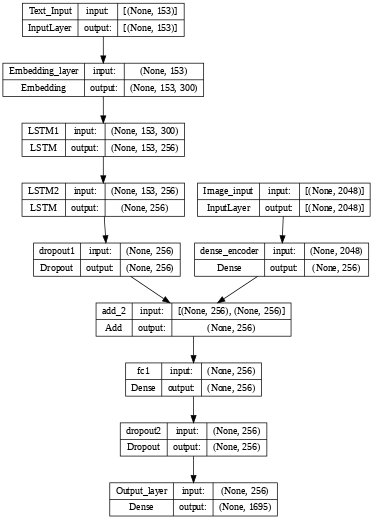

In [ ]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True, dpi = 52)

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
encoder_decoder.compile(optimizer, loss = maskedLoss)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
#training for 20 epochs
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_generator:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train.shape[0]//14)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_generator:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv.shape[0]//14)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')
    print('--------------------------------------------------------------------------------------------')

EPOCH :  1
Training Loss: 0.0034084314560791865,  Val Loss: 0.00316123377221326
Time Taken for this Epoch : 29.015708923339844 sec
--------------------------------------------------------------------------------------------
EPOCH :  2
Training Loss: 0.002773373177379067,  Val Loss: 0.002411141770724685
Time Taken for this Epoch : 12.801890134811401 sec
--------------------------------------------------------------------------------------------
EPOCH :  3
Training Loss: 0.002228615683772918,  Val Loss: 0.0020316705668870457
Time Taken for this Epoch : 12.561449527740479 sec
--------------------------------------------------------------------------------------------
EPOCH :  4
Training Loss: 0.0019852469112667335,  Val Loss: 0.001817951213198308
Time Taken for this Epoch : 12.525706768035889 sec
--------------------------------------------------------------------------------------------
EPOCH :  5
Training Loss: 0.0018328422627903445,  Val Loss: 0.0017488484736531973
Time Taken for this 

In [ ]:
model.save('encoder_decoder_final.h5')

In [ ]:
encoder_decoder.save('/content/drive/MyDrive/aayushi.h5')

In [ ]:
model.save('model.h5')

Text(0.5, 1.0, 'Loss per epoch')

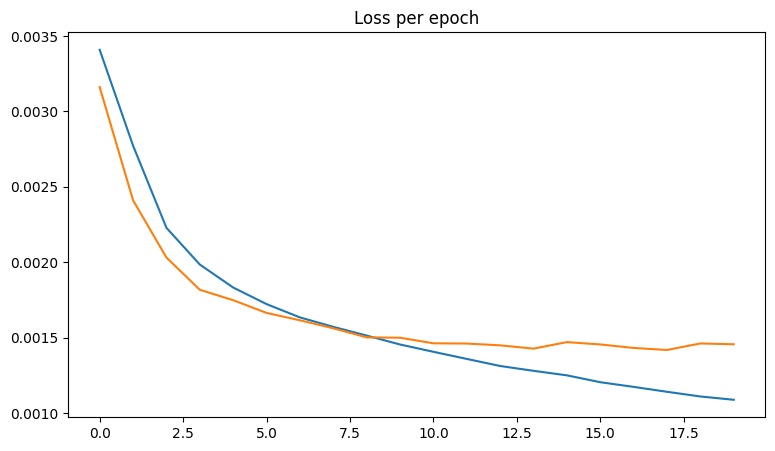

In [ ]:
plt.figure(figsize=(9,5))

plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)

plt.title('Loss per epoch')

In [ ]:
model.save('/content/drive/MyDrive/dlmodel.h5')

In [ ]:
encoder_decoder.load_weights("/content/encoder_decoder_epoch_5.h5")

NameError: ignored

In [ ]:
encoder_decoder.load_weights("/content/aayushi.h5")

NameError: ignored

In [ ]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [ ]:
cv_data.report[3200]

'startseq negative chest . cardiac and mediastinal contours are within normal limits .  the lungs are clear .  bony structures are intact .  endseq'

In [ ]:
# beam_width = 2
def beamsearch(image, beam_width = 2):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    img_features = cheXnet_Features[image]
    img_features = encoder_model.predict(img_features)
    finished_seq = []
    
    for i in range(153):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 153, padding='post')
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:] 
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

In [ ]:
cv_data['person_id'][3200]

'CXR2785_IM-1220_0'

In [ ]:
def get_result(beam_width,idx=0):
  
  plt.figure(figsize=(9,5))

  pre_Report,Score = beamsearch(cv_data['person_id'][idx],beam_width) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('Score is :',Score)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_data['report'][idx])

  plt.subplot(121)
  img = load_image(cv_data['image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_data['image2'][idx])
  plt.imshow(img[0])

1/1 [==============================] - 0s 23ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  no acute cardiopulmonary abnormality . the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette within normal limits . no acute cardiopulmonary abnormality identified .
Score is : 0.4049273193522822
------------------------------------------------------------------------------------------------------
Actual Report :  startseq negative chest . cardiac and mediastinal contours are within normal limits .  the lungs are clear .  bony structures are intact .  endseq


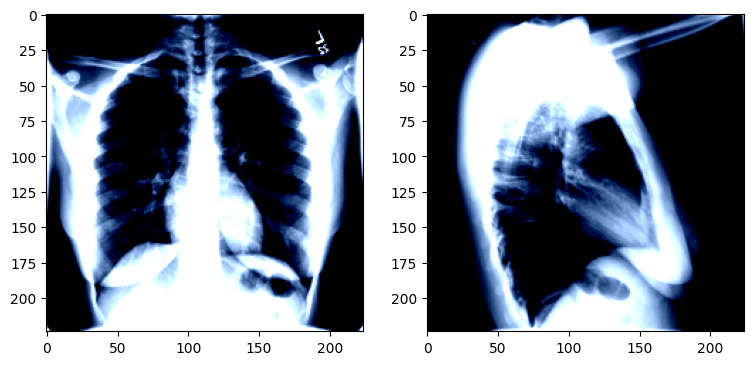

In [ ]:
get_result(2, 3200)

1/1 [==============================] - 0s 23ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  no acute cardiopulmonary abnormality . the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . no acute bony abnormality .
Score is : 0.4588092800695449
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiac silhouette normal size and configuration .  the mediastinum and perihilar structures appear unremarkable .  the lungs appear clear any focal infiltrates .  osseous structures appear within normal limits .  no pneumothora seen .  no free air appreciated beneath hemidiaphragms .  endseq


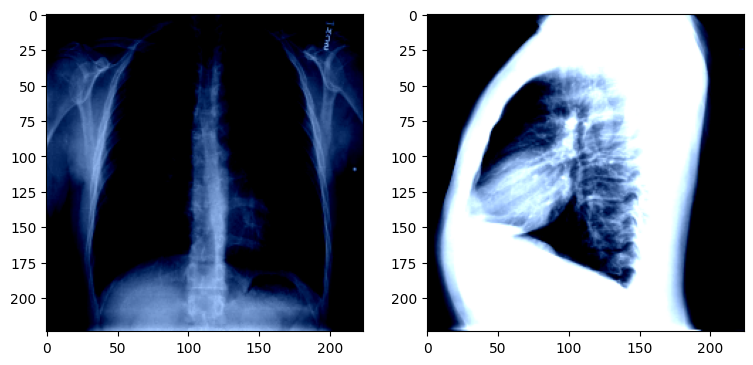

In [ ]:
get_result(2, 3500)

In [ ]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

In [ ]:
from tqdm.notebook import tqdm
# beam_width = 2
# '''CV'''

# bleu1 = []
# bleu2 = []
# bleu3 = []
# bleu4 = []
# for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
#     rep = rem_fullstops(rep)
#     rep = rep.split()[1:]
#     rep = rep[:len(rep)-1]
#     rep = ' '.join(e for e in rep)
    
#     pred_rep,score = beamsearch(img,2)
#     pred_rep = rem_fullstops(pred_rep)
    
#     bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
#     bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
#     bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
#     bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

# a = sum(bleu1)/X_test.shape[0]
# b = sum(bleu2)/X_test.shape[0]
# c = sum(bleu3)/X_test.shape[0]
# d = sum(bleu4)/X_test.shape[0]

# print('CV Bleu1 Score: ',a)
# print('CV Bleu2 Score: ',b)
# print('CV Bleu3 Score: ',c)
# print('CV Bleu4 Score: ',d)

# print('-----------------------------------------------------------------------')
# print("Avg CV Blue score:",(a+b+c+d)/4)

# print('=====================================================================================')

# beam_width = 2
'''TEST'''
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,2)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('Test Bleu1 Score: ',a)
print('Test Bleu2 Score: ',b)
print('Test Bleu3 Score: ',c)
print('Test Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Test Blue score:",(a+b+c+d)/4)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: ignored